In [1]:
### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


In [4]:
def unit(x, scale=1):
    _x = x ** scale
    _x = _x - torch.min(torch.min(_x), torch.zeros_like(_x))
    return _x / torch.max(_x)

def plot_magn(magn):
    scaled = magn ** 0.1
    plot(scaled / torch.max(scaled))
    
def plot_phase(phase):
    plot((phase + math.pi) / (2 * math.pi))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


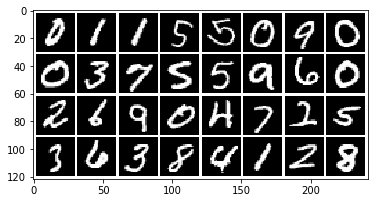

torch.Size([32, 1, 28, 28])


In [5]:
### LOAD DATA ###

dataset = 'mnist'
dataloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft ** 2, -1))
sample_phases = torch.atan2(sample_ft[..., 1], sample_ft[..., 0])

plot_grid(sample)
print(sample_magnitudes.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Magnitudes in real space:


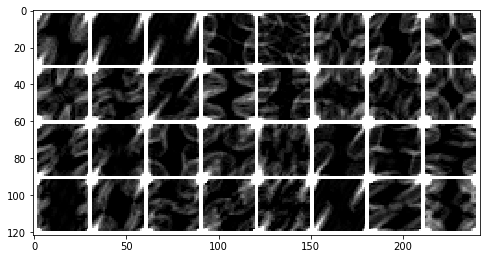

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 28, 28])
Phases in real space:


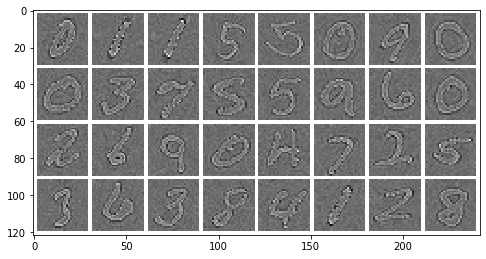

torch.Size([32, 1, 28, 28])
Min: tensor(-0.2179) Max: tensor(0.2910)
Mean: tensor(0.0013) Std: tensor(0.0357)


In [6]:
### Convert magnitudes and phasesto real space ###

# Set Im part of magnitudes = 0 and show in real space
sample_magn_real = nn.functional.pad(sample_magnitudes[... , None], (0, 1), 'constant', 0)
sample_Magn = torch.irfft(sample_magn_real, 2, onesided=False)

# Expand the magnitudes to Real and Im dimension and delete them from the phases
sample_magnitudes_cmplx = sample_magnitudes[..., None].expand(*sample_magnitudes.shape, 2)
sample_phases_cmplx = (sample_ft / (1e-16 + sample_magnitudes_cmplx))
sample_Phases = torch.irfft(sample_phases_cmplx, 2, onesided=False)

print("Magnitudes in real space:")
plot_grid(sample_Magn, figsize=(8,8))
print(sample_Magn.shape)

print("Phases in real space:")
plot_grid(unit(sample_Phases), figsize=(8,8))
print(sample_Phases.shape)
print("Min:", torch.min(sample_Phases), "Max:", torch.max(sample_Phases))
print("Mean:", torch.mean(sample_Phases), "Std:", torch.std(sample_Phases))

In [7]:
# Fully connected image network
class FCNet(nn.Module):

    __constants__ = ['mean', 'std']

    def __init__(self, imsize=(1, 28, 28), outsize=None, h=2048, mean=None, std=None):
        super(FCNet, self).__init__()
        print("Version 0.4")
        self.imsize = imsize
        if outsize is None:
            self.outsize = imsize
        else:
            self.outsize = outsize
        
        if mean is None:
            self.register_buffer('mean', torch.zeros(imsize))
        else:
            self.register_buffer('mean', torch.Tensor(mean))

        if std is None:
            self.register_buffer('std', torch.ones(imsize))
        else:
            self.register_buffer('std', torch.Tensor(std))
        
        self.layers = nn.Sequential(
            nn.Linear(imsize[0] * imsize[1] * imsize[2], h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h, self.outsize[0] * self.outsize[1] * self.outsize[2]),
        )
        
    def forward(self, x):
    
        N = x.shape[0]

        out = 0.0357 * self.layers(x.view(N, -1))
        return out.view(N, *self.outsize)

In [8]:
def calc_fourier(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    phs = torch.atan2(ft[..., 1], ft[..., 0])
    return ft, mags, phs

def calc_fourier_real(ft, mags):
    magn_real = nn.functional.pad(mags[... , None], (0, 1), 'constant', 0)
    Magns = torch.irfft(magn_real, 2, onesided=False)
    magnitudes_cmplx = mags[..., None].expand(*mags.shape, 2)
    phases_cmplx = (ft / (1e-16 + magnitudes_cmplx))
    Phases = torch.irfft(phases_cmplx, 2, onesided=False)
    return Magns, Phases

In [9]:
# Define loss

def gen_loss(Phase1, Phase2):
    return torch.mean((Phase1 - Phase2) ** 2)

In [10]:
### Create new models ###

gen = FCNet(imsize=(1, 28, 28), outsize=(1, 28, 28), h=2048)

Version 0.4


In [11]:
# Set training parameters

history = []
opt = optim.Adam(gen.parameters(), lr=1e-3)

In [12]:
# Initial loss

gen = gen.to(device)
sample = sample.to(device)
sample_ft, sample_magn, _ = calc_fourier(sample)
sample_Magns, sample_Phs = calc_fourier_real(sample_ft, sample_magn)

pred_Phs = gen(sample_magn)

loss = gen_loss(pred_Phs, sample_Phs)

print("Generator loss:", loss.item())

Generator loss: 0.0013394650304690003


In [13]:
def train_model(model, optimizer, device, loader_train, epochs=1):

    # move the model parameters to CPU/GPU
    model = model.to(device=device)
    
    history = []
    
    for e in range(epochs):

        for t, x in enumerate(loader_train):
            # put model to training mode
            model.train()
            
            # move x to device and reduce to magnitude information in fourier space
            x = x.to(device=device)

            ft, magn, _ = calc_fourier(x)
            _, Phs = calc_fourier_real(ft, magn)
            
            # compute loss as pixel wise distance to original input
            pred_Phs = model(magn)
            
            loss = gen_loss(pred_Phs, Phs)
            #loss = torch.mean((x - out_real)**2) + torch.mean((phases - out_phases)**2)
            history.append(loss.item())

            # perform backprop and learning step
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()

            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4}".format(e+1, t, history[-1]))
                
        plt.plot(history)
        plt.show()
                
    return history

epoch:  1 	 step:0 	 loss: 0.001348
epoch:  1 	 step:100 	 loss: 0.001241
epoch:  1 	 step:200 	 loss: 0.001221
epoch:  1 	 step:300 	 loss: 0.001226
epoch:  1 	 step:400 	 loss: 0.00121
epoch:  1 	 step:500 	 loss: 0.001187
epoch:  1 	 step:600 	 loss: 0.001199
epoch:  1 	 step:700 	 loss: 0.001194
epoch:  1 	 step:800 	 loss: 0.001203
epoch:  1 	 step:900 	 loss: 0.001191
epoch:  1 	 step:1000 	 loss: 0.001185
epoch:  1 	 step:1100 	 loss: 0.001181
epoch:  1 	 step:1200 	 loss: 0.001173
epoch:  1 	 step:1300 	 loss: 0.001194
epoch:  1 	 step:1400 	 loss: 0.00116
epoch:  1 	 step:1500 	 loss: 0.001185
epoch:  1 	 step:1600 	 loss: 0.001181
epoch:  1 	 step:1700 	 loss: 0.001179
epoch:  1 	 step:1800 	 loss: 0.001179


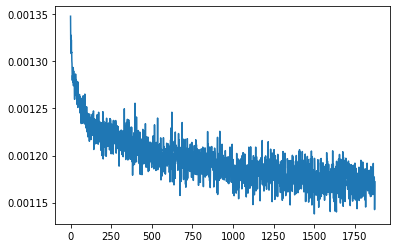

epoch:  2 	 step:0 	 loss: 0.001152
epoch:  2 	 step:100 	 loss: 0.00114
epoch:  2 	 step:200 	 loss: 0.001147
epoch:  2 	 step:300 	 loss: 0.001172
epoch:  2 	 step:400 	 loss: 0.001153
epoch:  2 	 step:500 	 loss: 0.001146
epoch:  2 	 step:600 	 loss: 0.001155
epoch:  2 	 step:700 	 loss: 0.001159
epoch:  2 	 step:800 	 loss: 0.001134
epoch:  2 	 step:900 	 loss: 0.001161
epoch:  2 	 step:1000 	 loss: 0.001158
epoch:  2 	 step:1100 	 loss: 0.001171
epoch:  2 	 step:1200 	 loss: 0.001152
epoch:  2 	 step:1300 	 loss: 0.001126
epoch:  2 	 step:1400 	 loss: 0.001128
epoch:  2 	 step:1500 	 loss: 0.001147
epoch:  2 	 step:1600 	 loss: 0.001193
epoch:  2 	 step:1700 	 loss: 0.001161
epoch:  2 	 step:1800 	 loss: 0.001109


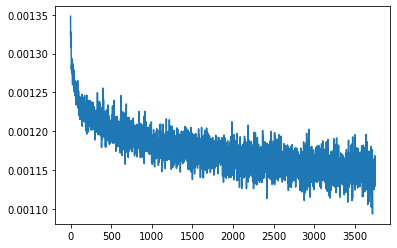

epoch:  3 	 step:0 	 loss: 0.001111
epoch:  3 	 step:100 	 loss: 0.001116
epoch:  3 	 step:200 	 loss: 0.001143
epoch:  3 	 step:300 	 loss: 0.001128
epoch:  3 	 step:400 	 loss: 0.001153
epoch:  3 	 step:500 	 loss: 0.001123
epoch:  3 	 step:600 	 loss: 0.00113
epoch:  3 	 step:700 	 loss: 0.001164
epoch:  3 	 step:800 	 loss: 0.00112
epoch:  3 	 step:900 	 loss: 0.001121
epoch:  3 	 step:1000 	 loss: 0.00115
epoch:  3 	 step:1100 	 loss: 0.001126
epoch:  3 	 step:1200 	 loss: 0.00113
epoch:  3 	 step:1300 	 loss: 0.001141
epoch:  3 	 step:1400 	 loss: 0.001121
epoch:  3 	 step:1500 	 loss: 0.001151
epoch:  3 	 step:1600 	 loss: 0.00113
epoch:  3 	 step:1700 	 loss: 0.001151
epoch:  3 	 step:1800 	 loss: 0.001136


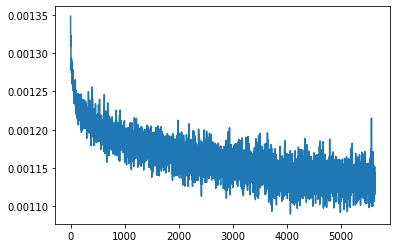

epoch:  4 	 step:0 	 loss: 0.00109
epoch:  4 	 step:100 	 loss: 0.001139
epoch:  4 	 step:200 	 loss: 0.001116
epoch:  4 	 step:300 	 loss: 0.001131
epoch:  4 	 step:400 	 loss: 0.001112
epoch:  4 	 step:500 	 loss: 0.001152
epoch:  4 	 step:600 	 loss: 0.001141
epoch:  4 	 step:700 	 loss: 0.00114
epoch:  4 	 step:800 	 loss: 0.001119
epoch:  4 	 step:900 	 loss: 0.001112
epoch:  4 	 step:1000 	 loss: 0.001098
epoch:  4 	 step:1100 	 loss: 0.001123
epoch:  4 	 step:1200 	 loss: 0.001122
epoch:  4 	 step:1300 	 loss: 0.00111
epoch:  4 	 step:1400 	 loss: 0.001109
epoch:  4 	 step:1500 	 loss: 0.001114
epoch:  4 	 step:1600 	 loss: 0.001124
epoch:  4 	 step:1700 	 loss: 0.001121
epoch:  4 	 step:1800 	 loss: 0.001122


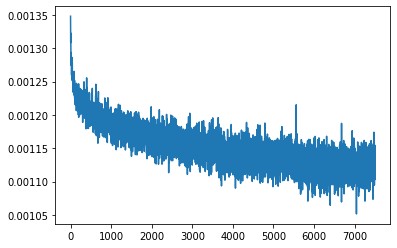

epoch:  5 	 step:0 	 loss: 0.001112
epoch:  5 	 step:100 	 loss: 0.001062
epoch:  5 	 step:200 	 loss: 0.001117
epoch:  5 	 step:300 	 loss: 0.001125
epoch:  5 	 step:400 	 loss: 0.001131
epoch:  5 	 step:500 	 loss: 0.001128
epoch:  5 	 step:600 	 loss: 0.001118
epoch:  5 	 step:700 	 loss: 0.001099
epoch:  5 	 step:800 	 loss: 0.001099
epoch:  5 	 step:900 	 loss: 0.0011
epoch:  5 	 step:1000 	 loss: 0.001146
epoch:  5 	 step:1100 	 loss: 0.001102
epoch:  5 	 step:1200 	 loss: 0.001086
epoch:  5 	 step:1300 	 loss: 0.001112
epoch:  5 	 step:1400 	 loss: 0.00111
epoch:  5 	 step:1500 	 loss: 0.001114
epoch:  5 	 step:1600 	 loss: 0.001141
epoch:  5 	 step:1700 	 loss: 0.001104
epoch:  5 	 step:1800 	 loss: 0.001123


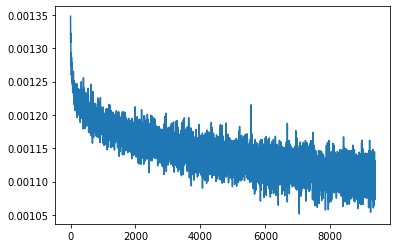

epoch:  6 	 step:0 	 loss: 0.001094
epoch:  6 	 step:100 	 loss: 0.001101
epoch:  6 	 step:200 	 loss: 0.001078
epoch:  6 	 step:300 	 loss: 0.001107
epoch:  6 	 step:400 	 loss: 0.001143
epoch:  6 	 step:500 	 loss: 0.001123
epoch:  6 	 step:600 	 loss: 0.001071
epoch:  6 	 step:700 	 loss: 0.001095
epoch:  6 	 step:800 	 loss: 0.001082
epoch:  6 	 step:900 	 loss: 0.001123
epoch:  6 	 step:1000 	 loss: 0.001103
epoch:  6 	 step:1100 	 loss: 0.001135
epoch:  6 	 step:1200 	 loss: 0.001092
epoch:  6 	 step:1300 	 loss: 0.001091
epoch:  6 	 step:1400 	 loss: 0.00107
epoch:  6 	 step:1500 	 loss: 0.001089
epoch:  6 	 step:1600 	 loss: 0.001068
epoch:  6 	 step:1700 	 loss: 0.001102
epoch:  6 	 step:1800 	 loss: 0.001129


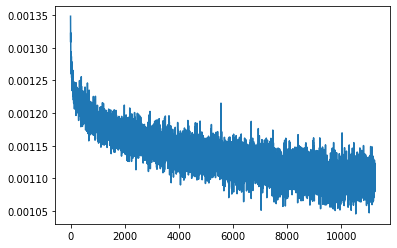

epoch:  7 	 step:0 	 loss: 0.001085
epoch:  7 	 step:100 	 loss: 0.001096
epoch:  7 	 step:200 	 loss: 0.001063
epoch:  7 	 step:300 	 loss: 0.001071
epoch:  7 	 step:400 	 loss: 0.001073
epoch:  7 	 step:500 	 loss: 0.001078
epoch:  7 	 step:600 	 loss: 0.001102
epoch:  7 	 step:700 	 loss: 0.001063
epoch:  7 	 step:800 	 loss: 0.001056
epoch:  7 	 step:900 	 loss: 0.00109
epoch:  7 	 step:1000 	 loss: 0.001103
epoch:  7 	 step:1100 	 loss: 0.001074
epoch:  7 	 step:1200 	 loss: 0.001099
epoch:  7 	 step:1300 	 loss: 0.001101
epoch:  7 	 step:1400 	 loss: 0.001101
epoch:  7 	 step:1500 	 loss: 0.001113
epoch:  7 	 step:1600 	 loss: 0.001094
epoch:  7 	 step:1700 	 loss: 0.001114
epoch:  7 	 step:1800 	 loss: 0.001072


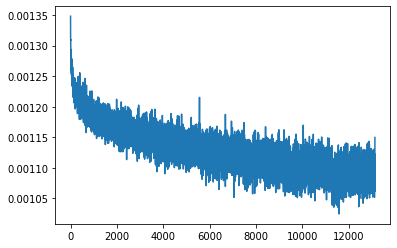

epoch:  8 	 step:0 	 loss: 0.001056
epoch:  8 	 step:100 	 loss: 0.001083
epoch:  8 	 step:200 	 loss: 0.001076
epoch:  8 	 step:300 	 loss: 0.00107
epoch:  8 	 step:400 	 loss: 0.001104
epoch:  8 	 step:500 	 loss: 0.00107
epoch:  8 	 step:600 	 loss: 0.001093
epoch:  8 	 step:700 	 loss: 0.001091
epoch:  8 	 step:800 	 loss: 0.001063
epoch:  8 	 step:900 	 loss: 0.001081
epoch:  8 	 step:1000 	 loss: 0.001087
epoch:  8 	 step:1100 	 loss: 0.001093
epoch:  8 	 step:1200 	 loss: 0.001111
epoch:  8 	 step:1300 	 loss: 0.001078
epoch:  8 	 step:1400 	 loss: 0.00113
epoch:  8 	 step:1500 	 loss: 0.001071
epoch:  8 	 step:1600 	 loss: 0.00107
epoch:  8 	 step:1700 	 loss: 0.001084
epoch:  8 	 step:1800 	 loss: 0.001103


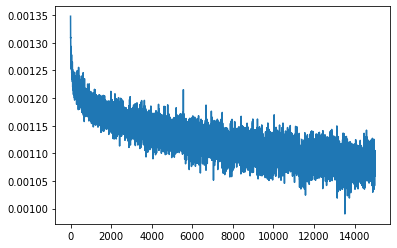

epoch:  9 	 step:0 	 loss: 0.001068
epoch:  9 	 step:100 	 loss: 0.001094
epoch:  9 	 step:200 	 loss: 0.001066
epoch:  9 	 step:300 	 loss: 0.001067
epoch:  9 	 step:400 	 loss: 0.001089
epoch:  9 	 step:500 	 loss: 0.001072
epoch:  9 	 step:600 	 loss: 0.001083
epoch:  9 	 step:700 	 loss: 0.001071
epoch:  9 	 step:800 	 loss: 0.001062
epoch:  9 	 step:900 	 loss: 0.001091
epoch:  9 	 step:1000 	 loss: 0.001035
epoch:  9 	 step:1100 	 loss: 0.001095
epoch:  9 	 step:1200 	 loss: 0.001089
epoch:  9 	 step:1300 	 loss: 0.001041
epoch:  9 	 step:1400 	 loss: 0.001095
epoch:  9 	 step:1500 	 loss: 0.001093
epoch:  9 	 step:1600 	 loss: 0.00109
epoch:  9 	 step:1700 	 loss: 0.001073
epoch:  9 	 step:1800 	 loss: 0.001064


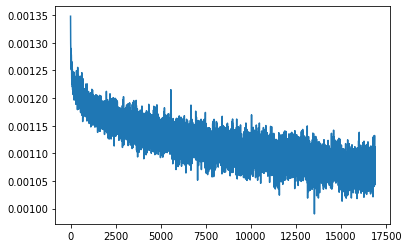

epoch: 10 	 step:0 	 loss: 0.001043
epoch: 10 	 step:100 	 loss: 0.001055
epoch: 10 	 step:200 	 loss: 0.001087
epoch: 10 	 step:300 	 loss: 0.001041
epoch: 10 	 step:400 	 loss: 0.001035
epoch: 10 	 step:500 	 loss: 0.001032
epoch: 10 	 step:600 	 loss: 0.001064
epoch: 10 	 step:700 	 loss: 0.001086
epoch: 10 	 step:800 	 loss: 0.001066
epoch: 10 	 step:900 	 loss: 0.00108
epoch: 10 	 step:1000 	 loss: 0.001042
epoch: 10 	 step:1100 	 loss: 0.001048
epoch: 10 	 step:1200 	 loss: 0.001065
epoch: 10 	 step:1300 	 loss: 0.001053
epoch: 10 	 step:1400 	 loss: 0.001111
epoch: 10 	 step:1500 	 loss: 0.00106
epoch: 10 	 step:1600 	 loss: 0.001081
epoch: 10 	 step:1700 	 loss: 0.001079
epoch: 10 	 step:1800 	 loss: 0.001073


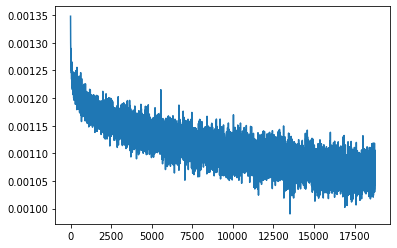

epoch: 11 	 step:0 	 loss: 0.001073
epoch: 11 	 step:100 	 loss: 0.001018
epoch: 11 	 step:200 	 loss: 0.001033
epoch: 11 	 step:300 	 loss: 0.001019
epoch: 11 	 step:400 	 loss: 0.001051
epoch: 11 	 step:500 	 loss: 0.001049
epoch: 11 	 step:600 	 loss: 0.001034
epoch: 11 	 step:700 	 loss: 0.001052
epoch: 11 	 step:800 	 loss: 0.001084
epoch: 11 	 step:900 	 loss: 0.001038
epoch: 11 	 step:1000 	 loss: 0.001075
epoch: 11 	 step:1100 	 loss: 0.001058
epoch: 11 	 step:1200 	 loss: 0.00108
epoch: 11 	 step:1300 	 loss: 0.001065
epoch: 11 	 step:1400 	 loss: 0.001057
epoch: 11 	 step:1500 	 loss: 0.001088
epoch: 11 	 step:1600 	 loss: 0.001045
epoch: 11 	 step:1700 	 loss: 0.001043
epoch: 11 	 step:1800 	 loss: 0.001064


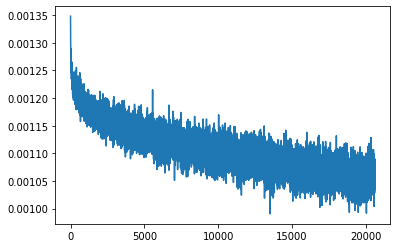

epoch: 12 	 step:0 	 loss: 0.001037
epoch: 12 	 step:100 	 loss: 0.001061
epoch: 12 	 step:200 	 loss: 0.001073
epoch: 12 	 step:300 	 loss: 0.001034
epoch: 12 	 step:400 	 loss: 0.001057
epoch: 12 	 step:500 	 loss: 0.001042
epoch: 12 	 step:600 	 loss: 0.001069
epoch: 12 	 step:700 	 loss: 0.001041
epoch: 12 	 step:800 	 loss: 0.001029
epoch: 12 	 step:900 	 loss: 0.001079
epoch: 12 	 step:1000 	 loss: 0.001065
epoch: 12 	 step:1100 	 loss: 0.001039
epoch: 12 	 step:1200 	 loss: 0.001089
epoch: 12 	 step:1300 	 loss: 0.001037
epoch: 12 	 step:1400 	 loss: 0.001031
epoch: 12 	 step:1500 	 loss: 0.001057
epoch: 12 	 step:1600 	 loss: 0.001044
epoch: 12 	 step:1700 	 loss: 0.001047
epoch: 12 	 step:1800 	 loss: 0.001074


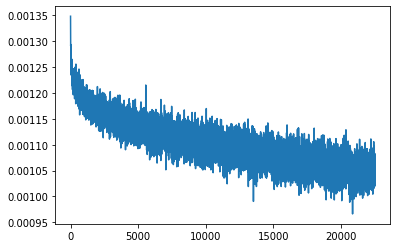

epoch: 13 	 step:0 	 loss: 0.001025
epoch: 13 	 step:100 	 loss: 0.001021
epoch: 13 	 step:200 	 loss: 0.001011
epoch: 13 	 step:300 	 loss: 0.001046
epoch: 13 	 step:400 	 loss: 0.001022
epoch: 13 	 step:500 	 loss: 0.001041
epoch: 13 	 step:600 	 loss: 0.001068
epoch: 13 	 step:700 	 loss: 0.001047
epoch: 13 	 step:800 	 loss: 0.001039
epoch: 13 	 step:900 	 loss: 0.001028
epoch: 13 	 step:1000 	 loss: 0.001052
epoch: 13 	 step:1100 	 loss: 0.001017
epoch: 13 	 step:1200 	 loss: 0.001049
epoch: 13 	 step:1300 	 loss: 0.001061
epoch: 13 	 step:1400 	 loss: 0.00103
epoch: 13 	 step:1500 	 loss: 0.001038
epoch: 13 	 step:1600 	 loss: 0.001066
epoch: 13 	 step:1700 	 loss: 0.001047
epoch: 13 	 step:1800 	 loss: 0.001034


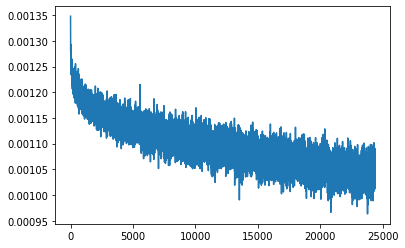

epoch: 14 	 step:0 	 loss: 0.001013
epoch: 14 	 step:100 	 loss: 0.001017
epoch: 14 	 step:200 	 loss: 0.0009856
epoch: 14 	 step:300 	 loss: 0.001037
epoch: 14 	 step:400 	 loss: 0.001039
epoch: 14 	 step:500 	 loss: 0.001068
epoch: 14 	 step:600 	 loss: 0.00105
epoch: 14 	 step:700 	 loss: 0.001041
epoch: 14 	 step:800 	 loss: 0.001027
epoch: 14 	 step:900 	 loss: 0.00102
epoch: 14 	 step:1000 	 loss: 0.00105
epoch: 14 	 step:1100 	 loss: 0.001015
epoch: 14 	 step:1200 	 loss: 0.001045
epoch: 14 	 step:1300 	 loss: 0.001036
epoch: 14 	 step:1400 	 loss: 0.001038
epoch: 14 	 step:1500 	 loss: 0.001033
epoch: 14 	 step:1600 	 loss: 0.001011
epoch: 14 	 step:1700 	 loss: 0.001035
epoch: 14 	 step:1800 	 loss: 0.001037


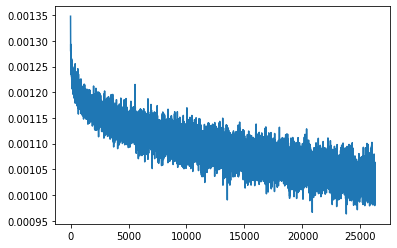

epoch: 15 	 step:0 	 loss: 0.001014
epoch: 15 	 step:100 	 loss: 0.001019
epoch: 15 	 step:200 	 loss: 0.001017
epoch: 15 	 step:300 	 loss: 0.001011
epoch: 15 	 step:400 	 loss: 0.00099
epoch: 15 	 step:500 	 loss: 0.001018
epoch: 15 	 step:600 	 loss: 0.0009936
epoch: 15 	 step:700 	 loss: 0.001031
epoch: 15 	 step:800 	 loss: 0.001023
epoch: 15 	 step:900 	 loss: 0.001028
epoch: 15 	 step:1000 	 loss: 0.0009888
epoch: 15 	 step:1100 	 loss: 0.001051
epoch: 15 	 step:1200 	 loss: 0.001044
epoch: 15 	 step:1300 	 loss: 0.001064
epoch: 15 	 step:1400 	 loss: 0.001017
epoch: 15 	 step:1500 	 loss: 0.001011
epoch: 15 	 step:1600 	 loss: 0.00103
epoch: 15 	 step:1700 	 loss: 0.001065
epoch: 15 	 step:1800 	 loss: 0.001036


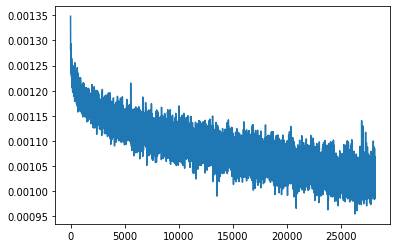

epoch: 16 	 step:0 	 loss: 0.0009735
epoch: 16 	 step:100 	 loss: 0.001003
epoch: 16 	 step:200 	 loss: 0.00102
epoch: 16 	 step:300 	 loss: 0.00103
epoch: 16 	 step:400 	 loss: 0.0009818
epoch: 16 	 step:500 	 loss: 0.001005
epoch: 16 	 step:600 	 loss: 0.0009923
epoch: 16 	 step:700 	 loss: 0.001013
epoch: 16 	 step:800 	 loss: 0.001023
epoch: 16 	 step:900 	 loss: 0.001006
epoch: 16 	 step:1000 	 loss: 0.001021
epoch: 16 	 step:1100 	 loss: 0.0009937
epoch: 16 	 step:1200 	 loss: 0.001025
epoch: 16 	 step:1300 	 loss: 0.001014
epoch: 16 	 step:1400 	 loss: 0.001037
epoch: 16 	 step:1500 	 loss: 0.0009814
epoch: 16 	 step:1600 	 loss: 0.001038
epoch: 16 	 step:1700 	 loss: 0.001066
epoch: 16 	 step:1800 	 loss: 0.001032


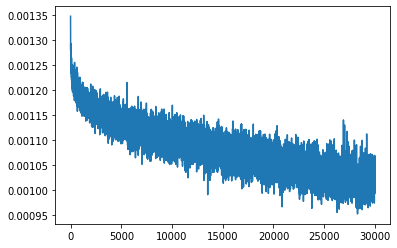

epoch: 17 	 step:0 	 loss: 0.0009946
epoch: 17 	 step:100 	 loss: 0.001004
epoch: 17 	 step:200 	 loss: 0.0009779
epoch: 17 	 step:300 	 loss: 0.001007
epoch: 17 	 step:400 	 loss: 0.0009769
epoch: 17 	 step:500 	 loss: 0.00105
epoch: 17 	 step:600 	 loss: 0.001005
epoch: 17 	 step:700 	 loss: 0.0009576
epoch: 17 	 step:800 	 loss: 0.0009791
epoch: 17 	 step:900 	 loss: 0.001035
epoch: 17 	 step:1000 	 loss: 0.001012
epoch: 17 	 step:1100 	 loss: 0.00103
epoch: 17 	 step:1200 	 loss: 0.001041
epoch: 17 	 step:1300 	 loss: 0.001043
epoch: 17 	 step:1400 	 loss: 0.001038
epoch: 17 	 step:1500 	 loss: 0.001036
epoch: 17 	 step:1600 	 loss: 0.001044
epoch: 17 	 step:1700 	 loss: 0.001002
epoch: 17 	 step:1800 	 loss: 0.001029


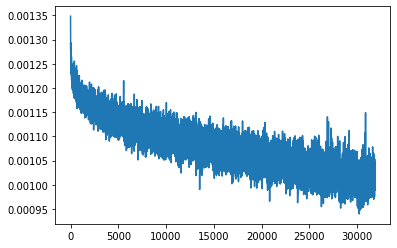

epoch: 18 	 step:0 	 loss: 0.0009932
epoch: 18 	 step:100 	 loss: 0.0009942
epoch: 18 	 step:200 	 loss: 0.0009752
epoch: 18 	 step:300 	 loss: 0.0009991
epoch: 18 	 step:400 	 loss: 0.001005
epoch: 18 	 step:500 	 loss: 0.001023
epoch: 18 	 step:600 	 loss: 0.001009
epoch: 18 	 step:700 	 loss: 0.0009913
epoch: 18 	 step:800 	 loss: 0.001004
epoch: 18 	 step:900 	 loss: 0.001001
epoch: 18 	 step:1000 	 loss: 0.001036
epoch: 18 	 step:1100 	 loss: 0.001025
epoch: 18 	 step:1200 	 loss: 0.001024
epoch: 18 	 step:1300 	 loss: 0.001031
epoch: 18 	 step:1400 	 loss: 0.0009946
epoch: 18 	 step:1500 	 loss: 0.0009988
epoch: 18 	 step:1600 	 loss: 0.001042
epoch: 18 	 step:1700 	 loss: 0.001023
epoch: 18 	 step:1800 	 loss: 0.001023


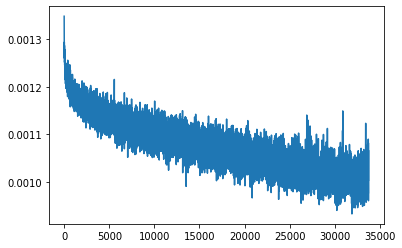

epoch: 19 	 step:0 	 loss: 0.0009661
epoch: 19 	 step:100 	 loss: 0.000989
epoch: 19 	 step:200 	 loss: 0.0009976
epoch: 19 	 step:300 	 loss: 0.001014
epoch: 19 	 step:400 	 loss: 0.0009886
epoch: 19 	 step:500 	 loss: 0.000971
epoch: 19 	 step:600 	 loss: 0.000992
epoch: 19 	 step:700 	 loss: 0.0009875
epoch: 19 	 step:800 	 loss: 0.001025
epoch: 19 	 step:900 	 loss: 0.001014
epoch: 19 	 step:1000 	 loss: 0.001012
epoch: 19 	 step:1100 	 loss: 0.0009802
epoch: 19 	 step:1200 	 loss: 0.0009859
epoch: 19 	 step:1300 	 loss: 0.001046
epoch: 19 	 step:1400 	 loss: 0.000972
epoch: 19 	 step:1500 	 loss: 0.0009987
epoch: 19 	 step:1600 	 loss: 0.001067
epoch: 19 	 step:1700 	 loss: 0.00102
epoch: 19 	 step:1800 	 loss: 0.0009848


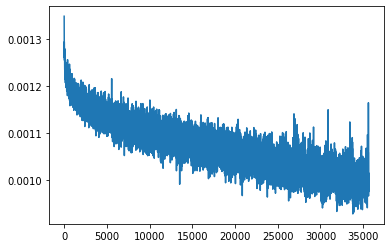

epoch: 20 	 step:0 	 loss: 0.001012
epoch: 20 	 step:100 	 loss: 0.0009968
epoch: 20 	 step:200 	 loss: 0.0009767
epoch: 20 	 step:300 	 loss: 0.0009682
epoch: 20 	 step:400 	 loss: 0.0009948
epoch: 20 	 step:500 	 loss: 0.0009995
epoch: 20 	 step:600 	 loss: 0.0009947
epoch: 20 	 step:700 	 loss: 0.001003
epoch: 20 	 step:800 	 loss: 0.001017
epoch: 20 	 step:900 	 loss: 0.0009724
epoch: 20 	 step:1000 	 loss: 0.0009933
epoch: 20 	 step:1100 	 loss: 0.0009835
epoch: 20 	 step:1200 	 loss: 0.0009747
epoch: 20 	 step:1300 	 loss: 0.0009853
epoch: 20 	 step:1400 	 loss: 0.0009711
epoch: 20 	 step:1500 	 loss: 0.0009939
epoch: 20 	 step:1600 	 loss: 0.001003
epoch: 20 	 step:1700 	 loss: 0.00101
epoch: 20 	 step:1800 	 loss: 0.001018


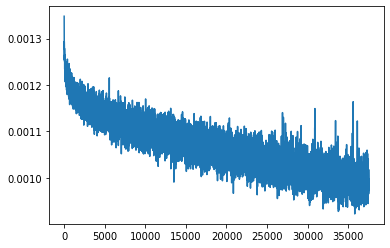

epoch: 21 	 step:0 	 loss: 0.0009623
epoch: 21 	 step:100 	 loss: 0.000974
epoch: 21 	 step:200 	 loss: 0.0009513
epoch: 21 	 step:300 	 loss: 0.0009937
epoch: 21 	 step:400 	 loss: 0.0009734
epoch: 21 	 step:500 	 loss: 0.000961
epoch: 21 	 step:600 	 loss: 0.0009981
epoch: 21 	 step:700 	 loss: 0.0009733
epoch: 21 	 step:800 	 loss: 0.001007
epoch: 21 	 step:900 	 loss: 0.0009898
epoch: 21 	 step:1000 	 loss: 0.0009454
epoch: 21 	 step:1100 	 loss: 0.0009743
epoch: 21 	 step:1200 	 loss: 0.0009954
epoch: 21 	 step:1300 	 loss: 0.0009557
epoch: 21 	 step:1400 	 loss: 0.000967
epoch: 21 	 step:1500 	 loss: 0.0009637
epoch: 21 	 step:1600 	 loss: 0.0009876
epoch: 21 	 step:1700 	 loss: 0.0009873
epoch: 21 	 step:1800 	 loss: 0.0009871


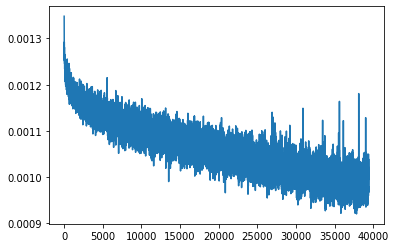

epoch: 22 	 step:0 	 loss: 0.000934
epoch: 22 	 step:100 	 loss: 0.0009533
epoch: 22 	 step:200 	 loss: 0.001003
epoch: 22 	 step:300 	 loss: 0.0009678
epoch: 22 	 step:400 	 loss: 0.0009487
epoch: 22 	 step:500 	 loss: 0.00096
epoch: 22 	 step:600 	 loss: 0.0009392
epoch: 22 	 step:700 	 loss: 0.0009743
epoch: 22 	 step:800 	 loss: 0.0009531
epoch: 22 	 step:900 	 loss: 0.001021
epoch: 22 	 step:1000 	 loss: 0.0009864
epoch: 22 	 step:1100 	 loss: 0.0009802
epoch: 22 	 step:1200 	 loss: 0.001004
epoch: 22 	 step:1300 	 loss: 0.0009708
epoch: 22 	 step:1400 	 loss: 0.0009733
epoch: 22 	 step:1500 	 loss: 0.001023
epoch: 22 	 step:1600 	 loss: 0.001005
epoch: 22 	 step:1700 	 loss: 0.0009929
epoch: 22 	 step:1800 	 loss: 0.001006


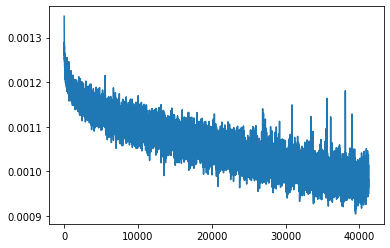

epoch: 23 	 step:0 	 loss: 0.0009647
epoch: 23 	 step:100 	 loss: 0.0009322
epoch: 23 	 step:200 	 loss: 0.0009599
epoch: 23 	 step:300 	 loss: 0.0009705
epoch: 23 	 step:400 	 loss: 0.0009711
epoch: 23 	 step:500 	 loss: 0.0009693
epoch: 23 	 step:600 	 loss: 0.000972
epoch: 23 	 step:700 	 loss: 0.0009763
epoch: 23 	 step:800 	 loss: 0.0009809
epoch: 23 	 step:900 	 loss: 0.0009751
epoch: 23 	 step:1000 	 loss: 0.000984
epoch: 23 	 step:1100 	 loss: 0.0009619
epoch: 23 	 step:1200 	 loss: 0.0009787
epoch: 23 	 step:1300 	 loss: 0.001003
epoch: 23 	 step:1400 	 loss: 0.001008
epoch: 23 	 step:1500 	 loss: 0.0009709
epoch: 23 	 step:1600 	 loss: 0.001001
epoch: 23 	 step:1700 	 loss: 0.0009595
epoch: 23 	 step:1800 	 loss: 0.0009795


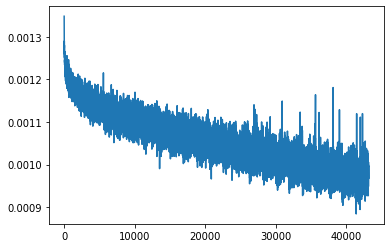

epoch: 24 	 step:0 	 loss: 0.000955
epoch: 24 	 step:100 	 loss: 0.000919
epoch: 24 	 step:200 	 loss: 0.0009826
epoch: 24 	 step:300 	 loss: 0.0009503
epoch: 24 	 step:400 	 loss: 0.0009397
epoch: 24 	 step:500 	 loss: 0.0009761
epoch: 24 	 step:600 	 loss: 0.0009373
epoch: 24 	 step:700 	 loss: 0.0009713
epoch: 24 	 step:800 	 loss: 0.0009616
epoch: 24 	 step:900 	 loss: 0.0009275
epoch: 24 	 step:1000 	 loss: 0.0009753
epoch: 24 	 step:1100 	 loss: 0.0009508
epoch: 24 	 step:1200 	 loss: 0.0009523
epoch: 24 	 step:1300 	 loss: 0.0009603
epoch: 24 	 step:1400 	 loss: 0.0009781
epoch: 24 	 step:1500 	 loss: 0.0009536
epoch: 24 	 step:1600 	 loss: 0.0009908
epoch: 24 	 step:1700 	 loss: 0.0009681
epoch: 24 	 step:1800 	 loss: 0.0009744


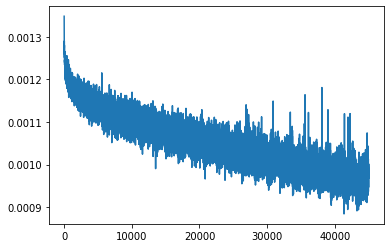

epoch: 25 	 step:0 	 loss: 0.0009158
epoch: 25 	 step:100 	 loss: 0.0009012
epoch: 25 	 step:200 	 loss: 0.0009361
epoch: 25 	 step:300 	 loss: 0.0009253
epoch: 25 	 step:400 	 loss: 0.000975
epoch: 25 	 step:500 	 loss: 0.0009061
epoch: 25 	 step:600 	 loss: 0.0009308
epoch: 25 	 step:700 	 loss: 0.0009584
epoch: 25 	 step:800 	 loss: 0.000952
epoch: 25 	 step:900 	 loss: 0.0009529
epoch: 25 	 step:1000 	 loss: 0.000975
epoch: 25 	 step:1100 	 loss: 0.0009614
epoch: 25 	 step:1200 	 loss: 0.0009313
epoch: 25 	 step:1300 	 loss: 0.0009422
epoch: 25 	 step:1400 	 loss: 0.0009654
epoch: 25 	 step:1500 	 loss: 0.0009898
epoch: 25 	 step:1600 	 loss: 0.0009418
epoch: 25 	 step:1700 	 loss: 0.0009364
epoch: 25 	 step:1800 	 loss: 0.000948


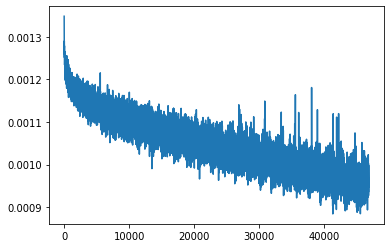

epoch: 26 	 step:0 	 loss: 0.0009073
epoch: 26 	 step:100 	 loss: 0.0009469
epoch: 26 	 step:200 	 loss: 0.0009541
epoch: 26 	 step:300 	 loss: 0.0009425
epoch: 26 	 step:400 	 loss: 0.0009104
epoch: 26 	 step:500 	 loss: 0.0009259
epoch: 26 	 step:600 	 loss: 0.0009591
epoch: 26 	 step:700 	 loss: 0.0009685
epoch: 26 	 step:800 	 loss: 0.0009432
epoch: 26 	 step:900 	 loss: 0.0009395
epoch: 26 	 step:1000 	 loss: 0.0009359
epoch: 26 	 step:1100 	 loss: 0.0009661
epoch: 26 	 step:1200 	 loss: 0.0009655
epoch: 26 	 step:1300 	 loss: 0.0009942
epoch: 26 	 step:1400 	 loss: 0.0009489
epoch: 26 	 step:1500 	 loss: 0.0009698
epoch: 26 	 step:1600 	 loss: 0.0009591
epoch: 26 	 step:1700 	 loss: 0.0009769
epoch: 26 	 step:1800 	 loss: 0.0009531


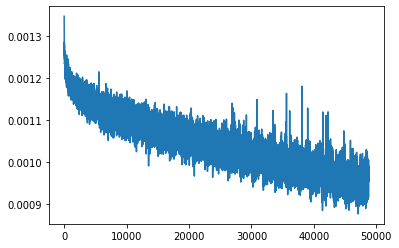

epoch: 27 	 step:0 	 loss: 0.0009264
epoch: 27 	 step:100 	 loss: 0.0009256
epoch: 27 	 step:200 	 loss: 0.0009187
epoch: 27 	 step:300 	 loss: 0.0009226
epoch: 27 	 step:400 	 loss: 0.0009076
epoch: 27 	 step:500 	 loss: 0.0009447
epoch: 27 	 step:600 	 loss: 0.0009551
epoch: 27 	 step:700 	 loss: 0.0009378
epoch: 27 	 step:800 	 loss: 0.0009382
epoch: 27 	 step:900 	 loss: 0.0009352
epoch: 27 	 step:1000 	 loss: 0.0009786
epoch: 27 	 step:1100 	 loss: 0.0009689
epoch: 27 	 step:1200 	 loss: 0.0009701
epoch: 27 	 step:1300 	 loss: 0.0009703
epoch: 27 	 step:1400 	 loss: 0.0009725
epoch: 27 	 step:1500 	 loss: 0.0009647
epoch: 27 	 step:1600 	 loss: 0.0009365
epoch: 27 	 step:1700 	 loss: 0.0009798
epoch: 27 	 step:1800 	 loss: 0.0009593


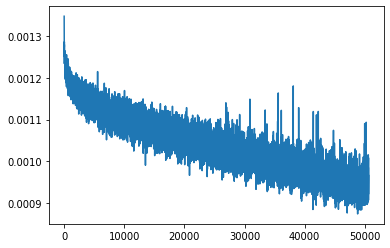

epoch: 28 	 step:0 	 loss: 0.0008846
epoch: 28 	 step:100 	 loss: 0.0009305
epoch: 28 	 step:200 	 loss: 0.0009181
epoch: 28 	 step:300 	 loss: 0.0009163
epoch: 28 	 step:400 	 loss: 0.0009152
epoch: 28 	 step:500 	 loss: 0.0009209
epoch: 28 	 step:600 	 loss: 0.0009438
epoch: 28 	 step:700 	 loss: 0.0009216
epoch: 28 	 step:800 	 loss: 0.0009173
epoch: 28 	 step:900 	 loss: 0.0009719
epoch: 28 	 step:1000 	 loss: 0.0009394
epoch: 28 	 step:1100 	 loss: 0.0009644
epoch: 28 	 step:1200 	 loss: 0.0009649
epoch: 28 	 step:1300 	 loss: 0.0009675
epoch: 28 	 step:1400 	 loss: 0.0009323
epoch: 28 	 step:1500 	 loss: 0.0009481
epoch: 28 	 step:1600 	 loss: 0.000927
epoch: 28 	 step:1700 	 loss: 0.0009816
epoch: 28 	 step:1800 	 loss: 0.0009761


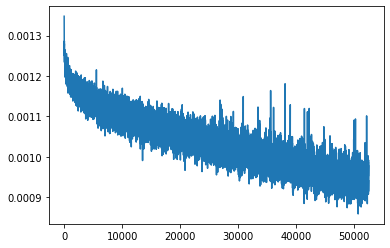

epoch: 29 	 step:0 	 loss: 0.000886
epoch: 29 	 step:100 	 loss: 0.0009163
epoch: 29 	 step:200 	 loss: 0.0009297
epoch: 29 	 step:300 	 loss: 0.0009125
epoch: 29 	 step:400 	 loss: 0.0009296
epoch: 29 	 step:500 	 loss: 0.0009183
epoch: 29 	 step:600 	 loss: 0.0009493
epoch: 29 	 step:700 	 loss: 0.0009365
epoch: 29 	 step:800 	 loss: 0.0008851
epoch: 29 	 step:900 	 loss: 0.0009564
epoch: 29 	 step:1000 	 loss: 0.0009843
epoch: 29 	 step:1100 	 loss: 0.0009224
epoch: 29 	 step:1200 	 loss: 0.0009596
epoch: 29 	 step:1300 	 loss: 0.0009328
epoch: 29 	 step:1400 	 loss: 0.0009304
epoch: 29 	 step:1500 	 loss: 0.0009529
epoch: 29 	 step:1600 	 loss: 0.0009219
epoch: 29 	 step:1700 	 loss: 0.0009557
epoch: 29 	 step:1800 	 loss: 0.0009705


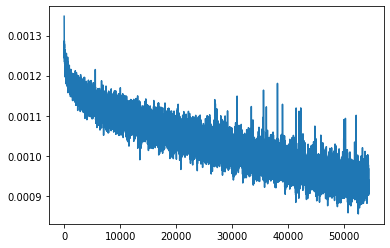

epoch: 30 	 step:0 	 loss: 0.0009097
epoch: 30 	 step:100 	 loss: 0.0009063
epoch: 30 	 step:200 	 loss: 0.0009115
epoch: 30 	 step:300 	 loss: 0.0009196
epoch: 30 	 step:400 	 loss: 0.0009013
epoch: 30 	 step:500 	 loss: 0.0009518
epoch: 30 	 step:600 	 loss: 0.0009628
epoch: 30 	 step:700 	 loss: 0.0009499
epoch: 30 	 step:800 	 loss: 0.0009079
epoch: 30 	 step:900 	 loss: 0.0009468
epoch: 30 	 step:1000 	 loss: 0.0009255
epoch: 30 	 step:1100 	 loss: 0.0009143
epoch: 30 	 step:1200 	 loss: 0.0009358
epoch: 30 	 step:1300 	 loss: 0.0009751
epoch: 30 	 step:1400 	 loss: 0.0009007
epoch: 30 	 step:1500 	 loss: 0.0009413
epoch: 30 	 step:1600 	 loss: 0.0009414
epoch: 30 	 step:1700 	 loss: 0.0009241
epoch: 30 	 step:1800 	 loss: 0.0009565


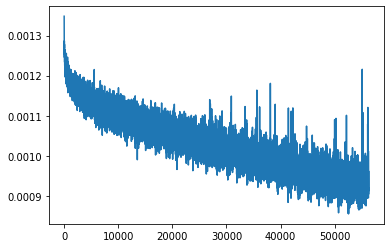

epoch: 31 	 step:0 	 loss: 0.0009359
epoch: 31 	 step:100 	 loss: 0.0009013
epoch: 31 	 step:200 	 loss: 0.0009153
epoch: 31 	 step:300 	 loss: 0.0009146
epoch: 31 	 step:400 	 loss: 0.0009094
epoch: 31 	 step:500 	 loss: 0.0009304
epoch: 31 	 step:600 	 loss: 0.000903
epoch: 31 	 step:700 	 loss: 0.0008945
epoch: 31 	 step:800 	 loss: 0.0009325
epoch: 31 	 step:900 	 loss: 0.0009165
epoch: 31 	 step:1000 	 loss: 0.0009329
epoch: 31 	 step:1100 	 loss: 0.0009216
epoch: 31 	 step:1200 	 loss: 0.0009083
epoch: 31 	 step:1300 	 loss: 0.0009598
epoch: 31 	 step:1400 	 loss: 0.0009218
epoch: 31 	 step:1500 	 loss: 0.0009267
epoch: 31 	 step:1600 	 loss: 0.0009172
epoch: 31 	 step:1700 	 loss: 0.0009608
epoch: 31 	 step:1800 	 loss: 0.0009492


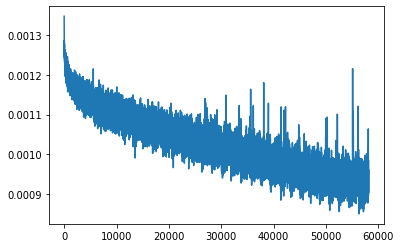

epoch: 32 	 step:0 	 loss: 0.0009286
epoch: 32 	 step:100 	 loss: 0.0009169
epoch: 32 	 step:200 	 loss: 0.0009004
epoch: 32 	 step:300 	 loss: 0.0009073
epoch: 32 	 step:400 	 loss: 0.0009225
epoch: 32 	 step:500 	 loss: 0.0009248
epoch: 32 	 step:600 	 loss: 0.0008898
epoch: 32 	 step:700 	 loss: 0.0008969
epoch: 32 	 step:800 	 loss: 0.0009141
epoch: 32 	 step:900 	 loss: 0.000908
epoch: 32 	 step:1000 	 loss: 0.0009376
epoch: 32 	 step:1100 	 loss: 0.0009115
epoch: 32 	 step:1200 	 loss: 0.0009221
epoch: 32 	 step:1300 	 loss: 0.0009105
epoch: 32 	 step:1400 	 loss: 0.0009457
epoch: 32 	 step:1500 	 loss: 0.0009242
epoch: 32 	 step:1600 	 loss: 0.0009313
epoch: 32 	 step:1700 	 loss: 0.0009165
epoch: 32 	 step:1800 	 loss: 0.000936


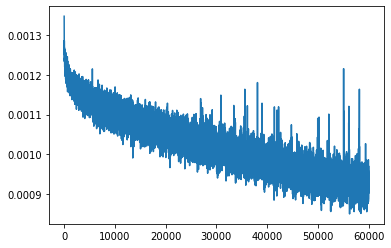

epoch: 33 	 step:0 	 loss: 0.0008554
epoch: 33 	 step:100 	 loss: 0.0009179
epoch: 33 	 step:200 	 loss: 0.0008701
epoch: 33 	 step:300 	 loss: 0.0009112
epoch: 33 	 step:400 	 loss: 0.0008781
epoch: 33 	 step:500 	 loss: 0.0009228
epoch: 33 	 step:600 	 loss: 0.0009124
epoch: 33 	 step:700 	 loss: 0.0009045
epoch: 33 	 step:800 	 loss: 0.0009182
epoch: 33 	 step:900 	 loss: 0.0009395
epoch: 33 	 step:1000 	 loss: 0.0008957
epoch: 33 	 step:1100 	 loss: 0.0009027
epoch: 33 	 step:1200 	 loss: 0.0009339
epoch: 33 	 step:1300 	 loss: 0.0009077
epoch: 33 	 step:1400 	 loss: 0.0009536
epoch: 33 	 step:1500 	 loss: 0.0009263
epoch: 33 	 step:1600 	 loss: 0.0009389
epoch: 33 	 step:1700 	 loss: 0.0009028
epoch: 33 	 step:1800 	 loss: 0.0009147


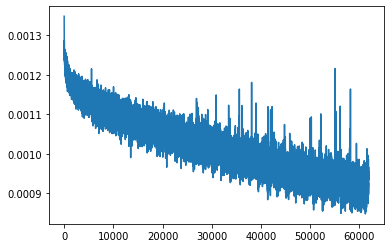

epoch: 34 	 step:0 	 loss: 0.0008966
epoch: 34 	 step:100 	 loss: 0.000913
epoch: 34 	 step:200 	 loss: 0.0008738
epoch: 34 	 step:300 	 loss: 0.0009138
epoch: 34 	 step:400 	 loss: 0.0008914
epoch: 34 	 step:500 	 loss: 0.0008755
epoch: 34 	 step:600 	 loss: 0.0009167
epoch: 34 	 step:700 	 loss: 0.0009258
epoch: 34 	 step:800 	 loss: 0.0009124
epoch: 34 	 step:900 	 loss: 0.0009251
epoch: 34 	 step:1000 	 loss: 0.0009091
epoch: 34 	 step:1100 	 loss: 0.0009109
epoch: 34 	 step:1200 	 loss: 0.00092
epoch: 34 	 step:1300 	 loss: 0.0009318
epoch: 34 	 step:1400 	 loss: 0.000931
epoch: 34 	 step:1500 	 loss: 0.0009119
epoch: 34 	 step:1600 	 loss: 0.0009609
epoch: 34 	 step:1700 	 loss: 0.000904
epoch: 34 	 step:1800 	 loss: 0.0009288


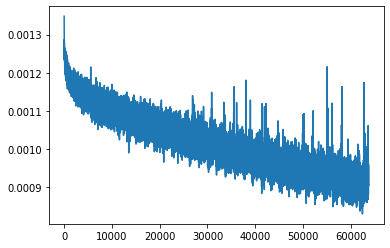

epoch: 35 	 step:0 	 loss: 0.000903
epoch: 35 	 step:100 	 loss: 0.0008962
epoch: 35 	 step:200 	 loss: 0.0009165
epoch: 35 	 step:300 	 loss: 0.0008787
epoch: 35 	 step:400 	 loss: 0.0008827
epoch: 35 	 step:500 	 loss: 0.0008885
epoch: 35 	 step:600 	 loss: 0.0008787
epoch: 35 	 step:700 	 loss: 0.0008699
epoch: 35 	 step:800 	 loss: 0.0009125
epoch: 35 	 step:900 	 loss: 0.0008973
epoch: 35 	 step:1000 	 loss: 0.0009154
epoch: 35 	 step:1100 	 loss: 0.0009073
epoch: 35 	 step:1200 	 loss: 0.0009219
epoch: 35 	 step:1300 	 loss: 0.0009644
epoch: 35 	 step:1400 	 loss: 0.0009074
epoch: 35 	 step:1500 	 loss: 0.0009508
epoch: 35 	 step:1600 	 loss: 0.000908
epoch: 35 	 step:1700 	 loss: 0.0008973
epoch: 35 	 step:1800 	 loss: 0.0008927


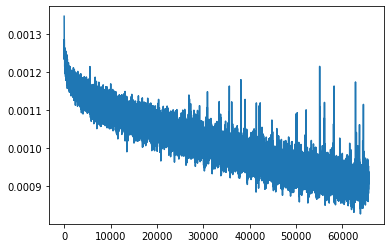

epoch: 36 	 step:0 	 loss: 0.0008997
epoch: 36 	 step:100 	 loss: 0.0009006
epoch: 36 	 step:200 	 loss: 0.0008924
epoch: 36 	 step:300 	 loss: 0.0008955
epoch: 36 	 step:400 	 loss: 0.0009134
epoch: 36 	 step:500 	 loss: 0.0009178
epoch: 36 	 step:600 	 loss: 0.000882
epoch: 36 	 step:700 	 loss: 0.0009035
epoch: 36 	 step:800 	 loss: 0.000887
epoch: 36 	 step:900 	 loss: 0.0009279
epoch: 36 	 step:1000 	 loss: 0.0009031
epoch: 36 	 step:1100 	 loss: 0.0009453
epoch: 36 	 step:1200 	 loss: 0.0009294
epoch: 36 	 step:1300 	 loss: 0.0009175
epoch: 36 	 step:1400 	 loss: 0.0008976
epoch: 36 	 step:1500 	 loss: 0.0009088
epoch: 36 	 step:1600 	 loss: 0.0009098
epoch: 36 	 step:1700 	 loss: 0.0009333
epoch: 36 	 step:1800 	 loss: 0.0008846


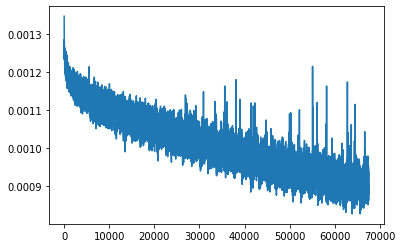

epoch: 37 	 step:0 	 loss: 0.0008647
epoch: 37 	 step:100 	 loss: 0.0009104
epoch: 37 	 step:200 	 loss: 0.0008735
epoch: 37 	 step:300 	 loss: 0.0009073
epoch: 37 	 step:400 	 loss: 0.0009008
epoch: 37 	 step:500 	 loss: 0.000859
epoch: 37 	 step:600 	 loss: 0.0009132
epoch: 37 	 step:700 	 loss: 0.0008906
epoch: 37 	 step:800 	 loss: 0.0008861
epoch: 37 	 step:900 	 loss: 0.0009018
epoch: 37 	 step:1000 	 loss: 0.0008896
epoch: 37 	 step:1100 	 loss: 0.0009005
epoch: 37 	 step:1200 	 loss: 0.0008845
epoch: 37 	 step:1300 	 loss: 0.000945
epoch: 37 	 step:1400 	 loss: 0.0009326
epoch: 37 	 step:1500 	 loss: 0.000903
epoch: 37 	 step:1600 	 loss: 0.0008857
epoch: 37 	 step:1700 	 loss: 0.0008976
epoch: 37 	 step:1800 	 loss: 0.000929


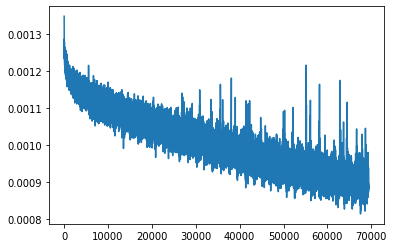

epoch: 38 	 step:0 	 loss: 0.0008404
epoch: 38 	 step:100 	 loss: 0.0008782
epoch: 38 	 step:200 	 loss: 0.0008831
epoch: 38 	 step:300 	 loss: 0.00087
epoch: 38 	 step:400 	 loss: 0.0008809
epoch: 38 	 step:500 	 loss: 0.0009174
epoch: 38 	 step:600 	 loss: 0.0008948
epoch: 38 	 step:700 	 loss: 0.0008887
epoch: 38 	 step:800 	 loss: 0.000911
epoch: 38 	 step:900 	 loss: 0.0008754
epoch: 38 	 step:1000 	 loss: 0.0008671
epoch: 38 	 step:1100 	 loss: 0.0009204
epoch: 38 	 step:1200 	 loss: 0.0008753
epoch: 38 	 step:1300 	 loss: 0.0008854
epoch: 38 	 step:1400 	 loss: 0.0008627
epoch: 38 	 step:1500 	 loss: 0.0009154
epoch: 38 	 step:1600 	 loss: 0.0008909
epoch: 38 	 step:1700 	 loss: 0.000874
epoch: 38 	 step:1800 	 loss: 0.0009172


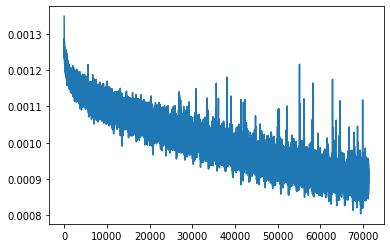

epoch: 39 	 step:0 	 loss: 0.0009151
epoch: 39 	 step:100 	 loss: 0.0009057
epoch: 39 	 step:200 	 loss: 0.0008662
epoch: 39 	 step:300 	 loss: 0.0008677
epoch: 39 	 step:400 	 loss: 0.0009139
epoch: 39 	 step:500 	 loss: 0.0009058
epoch: 39 	 step:600 	 loss: 0.0009153
epoch: 39 	 step:700 	 loss: 0.0009121
epoch: 39 	 step:800 	 loss: 0.0009001
epoch: 39 	 step:900 	 loss: 0.0008778
epoch: 39 	 step:1000 	 loss: 0.000881
epoch: 39 	 step:1100 	 loss: 0.0008891
epoch: 39 	 step:1200 	 loss: 0.0008968
epoch: 39 	 step:1300 	 loss: 0.0008689
epoch: 39 	 step:1400 	 loss: 0.0008903
epoch: 39 	 step:1500 	 loss: 0.0008636
epoch: 39 	 step:1600 	 loss: 0.0009008
epoch: 39 	 step:1700 	 loss: 0.0008863
epoch: 39 	 step:1800 	 loss: 0.0009137


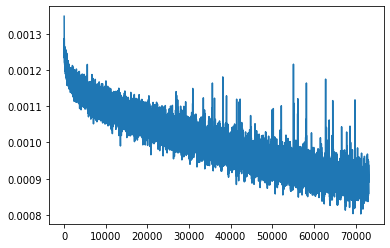

epoch: 40 	 step:0 	 loss: 0.0008568
epoch: 40 	 step:100 	 loss: 0.0008938
epoch: 40 	 step:200 	 loss: 0.0008601
epoch: 40 	 step:300 	 loss: 0.0008691
epoch: 40 	 step:400 	 loss: 0.0009079
epoch: 40 	 step:500 	 loss: 0.0008585
epoch: 40 	 step:600 	 loss: 0.0008828
epoch: 40 	 step:700 	 loss: 0.0008578
epoch: 40 	 step:800 	 loss: 0.0009052
epoch: 40 	 step:900 	 loss: 0.000882
epoch: 40 	 step:1000 	 loss: 0.0008533
epoch: 40 	 step:1100 	 loss: 0.0008844
epoch: 40 	 step:1200 	 loss: 0.0008888
epoch: 40 	 step:1300 	 loss: 0.0008591
epoch: 40 	 step:1400 	 loss: 0.0009124
epoch: 40 	 step:1500 	 loss: 0.0008638
epoch: 40 	 step:1600 	 loss: 0.0008623
epoch: 40 	 step:1700 	 loss: 0.0008958
epoch: 40 	 step:1800 	 loss: 0.0009361


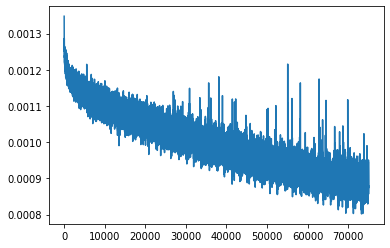

epoch: 41 	 step:0 	 loss: 0.0008501
epoch: 41 	 step:100 	 loss: 0.0008823
epoch: 41 	 step:200 	 loss: 0.0008511
epoch: 41 	 step:300 	 loss: 0.0009125
epoch: 41 	 step:400 	 loss: 0.0008622
epoch: 41 	 step:500 	 loss: 0.0009168
epoch: 41 	 step:600 	 loss: 0.0008906
epoch: 41 	 step:700 	 loss: 0.0008819
epoch: 41 	 step:800 	 loss: 0.000928
epoch: 41 	 step:900 	 loss: 0.0008805
epoch: 41 	 step:1000 	 loss: 0.0008755
epoch: 41 	 step:1100 	 loss: 0.0008644
epoch: 41 	 step:1200 	 loss: 0.0008982
epoch: 41 	 step:1300 	 loss: 0.0009042
epoch: 41 	 step:1400 	 loss: 0.0008844
epoch: 41 	 step:1500 	 loss: 0.00089
epoch: 41 	 step:1600 	 loss: 0.0008979
epoch: 41 	 step:1700 	 loss: 0.000886
epoch: 41 	 step:1800 	 loss: 0.0008931


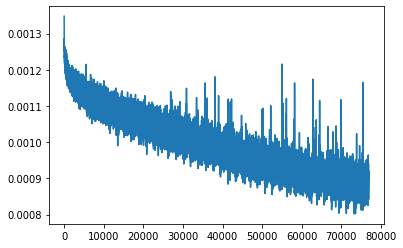

epoch: 42 	 step:0 	 loss: 0.0008357
epoch: 42 	 step:100 	 loss: 0.0008828
epoch: 42 	 step:200 	 loss: 0.0008772
epoch: 42 	 step:300 	 loss: 0.0008856
epoch: 42 	 step:400 	 loss: 0.0008806
epoch: 42 	 step:500 	 loss: 0.0008803
epoch: 42 	 step:600 	 loss: 0.0009029
epoch: 42 	 step:700 	 loss: 0.0008681
epoch: 42 	 step:800 	 loss: 0.0008169
epoch: 42 	 step:900 	 loss: 0.0008585
epoch: 42 	 step:1000 	 loss: 0.0008728
epoch: 42 	 step:1100 	 loss: 0.0008706
epoch: 42 	 step:1200 	 loss: 0.0008986
epoch: 42 	 step:1300 	 loss: 0.000954
epoch: 42 	 step:1400 	 loss: 0.0009188
epoch: 42 	 step:1500 	 loss: 0.0008947
epoch: 42 	 step:1600 	 loss: 0.0008848
epoch: 42 	 step:1700 	 loss: 0.0008856
epoch: 42 	 step:1800 	 loss: 0.0009215


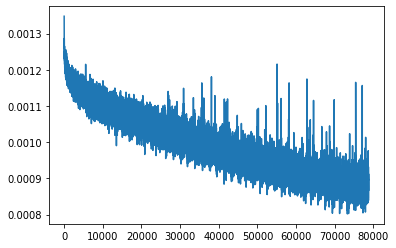

epoch: 43 	 step:0 	 loss: 0.0008566
epoch: 43 	 step:100 	 loss: 0.0008116
epoch: 43 	 step:200 	 loss: 0.0008594
epoch: 43 	 step:300 	 loss: 0.0008517
epoch: 43 	 step:400 	 loss: 0.0008641
epoch: 43 	 step:500 	 loss: 0.000851
epoch: 43 	 step:600 	 loss: 0.0008805
epoch: 43 	 step:700 	 loss: 0.0008392
epoch: 43 	 step:800 	 loss: 0.0009071
epoch: 43 	 step:900 	 loss: 0.0008528
epoch: 43 	 step:1000 	 loss: 0.0008726
epoch: 43 	 step:1100 	 loss: 0.0008858
epoch: 43 	 step:1200 	 loss: 0.0008715
epoch: 43 	 step:1300 	 loss: 0.0009019
epoch: 43 	 step:1400 	 loss: 0.0008844
epoch: 43 	 step:1500 	 loss: 0.0009071
epoch: 43 	 step:1600 	 loss: 0.0008455
epoch: 43 	 step:1700 	 loss: 0.000886
epoch: 43 	 step:1800 	 loss: 0.0008771


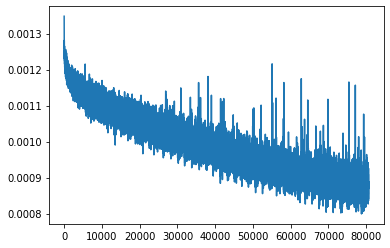

epoch: 44 	 step:0 	 loss: 0.0008367
epoch: 44 	 step:100 	 loss: 0.0008621
epoch: 44 	 step:200 	 loss: 0.0008799
epoch: 44 	 step:300 	 loss: 0.0008744
epoch: 44 	 step:400 	 loss: 0.0009097
epoch: 44 	 step:500 	 loss: 0.0008762
epoch: 44 	 step:600 	 loss: 0.0008851
epoch: 44 	 step:700 	 loss: 0.0008724
epoch: 44 	 step:800 	 loss: 0.0008782
epoch: 44 	 step:900 	 loss: 0.0008793
epoch: 44 	 step:1000 	 loss: 0.0008489
epoch: 44 	 step:1100 	 loss: 0.0008466
epoch: 44 	 step:1200 	 loss: 0.0008648
epoch: 44 	 step:1300 	 loss: 0.0009446
epoch: 44 	 step:1400 	 loss: 0.0009049
epoch: 44 	 step:1500 	 loss: 0.0008947
epoch: 44 	 step:1600 	 loss: 0.0008685
epoch: 44 	 step:1700 	 loss: 0.0008765
epoch: 44 	 step:1800 	 loss: 0.0008399


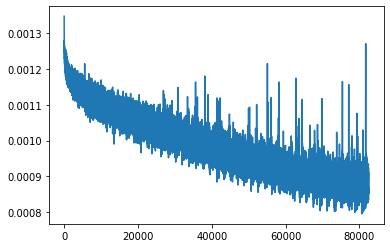

epoch: 45 	 step:0 	 loss: 0.000834
epoch: 45 	 step:100 	 loss: 0.000837
epoch: 45 	 step:200 	 loss: 0.0008637
epoch: 45 	 step:300 	 loss: 0.0008356
epoch: 45 	 step:400 	 loss: 0.0008225
epoch: 45 	 step:500 	 loss: 0.0008741
epoch: 45 	 step:600 	 loss: 0.0008355
epoch: 45 	 step:700 	 loss: 0.0008404
epoch: 45 	 step:800 	 loss: 0.0008861
epoch: 45 	 step:900 	 loss: 0.0008573
epoch: 45 	 step:1000 	 loss: 0.0009012
epoch: 45 	 step:1100 	 loss: 0.000909
epoch: 45 	 step:1200 	 loss: 0.0008756
epoch: 45 	 step:1300 	 loss: 0.0008999
epoch: 45 	 step:1400 	 loss: 0.0008521
epoch: 45 	 step:1500 	 loss: 0.0009123
epoch: 45 	 step:1600 	 loss: 0.0008265
epoch: 45 	 step:1700 	 loss: 0.0008797
epoch: 45 	 step:1800 	 loss: 0.0008782


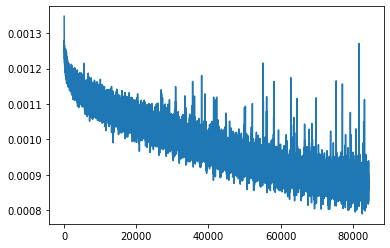

epoch: 46 	 step:0 	 loss: 0.0008361
epoch: 46 	 step:100 	 loss: 0.0008406
epoch: 46 	 step:200 	 loss: 0.0008288
epoch: 46 	 step:300 	 loss: 0.0008724
epoch: 46 	 step:400 	 loss: 0.0008631
epoch: 46 	 step:500 	 loss: 0.0008231
epoch: 46 	 step:600 	 loss: 0.0008551
epoch: 46 	 step:700 	 loss: 0.0008432
epoch: 46 	 step:800 	 loss: 0.0008886
epoch: 46 	 step:900 	 loss: 0.0008338
epoch: 46 	 step:1000 	 loss: 0.000881
epoch: 46 	 step:1100 	 loss: 0.0009013
epoch: 46 	 step:1200 	 loss: 0.0008686
epoch: 46 	 step:1300 	 loss: 0.0009061
epoch: 46 	 step:1400 	 loss: 0.0008927
epoch: 46 	 step:1500 	 loss: 0.0008539
epoch: 46 	 step:1600 	 loss: 0.000858
epoch: 46 	 step:1700 	 loss: 0.0008792
epoch: 46 	 step:1800 	 loss: 0.0008481


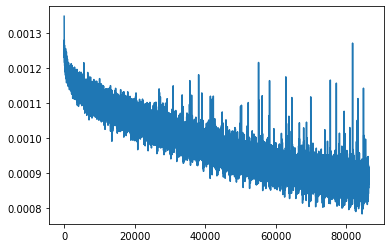

epoch: 47 	 step:0 	 loss: 0.0008952
epoch: 47 	 step:100 	 loss: 0.0008382
epoch: 47 	 step:200 	 loss: 0.0008525
epoch: 47 	 step:300 	 loss: 0.000867
epoch: 47 	 step:400 	 loss: 0.0008469
epoch: 47 	 step:500 	 loss: 0.0008188
epoch: 47 	 step:600 	 loss: 0.0008959
epoch: 47 	 step:700 	 loss: 0.0008202
epoch: 47 	 step:800 	 loss: 0.0008679
epoch: 47 	 step:900 	 loss: 0.0008613
epoch: 47 	 step:1000 	 loss: 0.0008759
epoch: 47 	 step:1100 	 loss: 0.0008757
epoch: 47 	 step:1200 	 loss: 0.0008716
epoch: 47 	 step:1300 	 loss: 0.0008707
epoch: 47 	 step:1400 	 loss: 0.0008782
epoch: 47 	 step:1500 	 loss: 0.0008652
epoch: 47 	 step:1600 	 loss: 0.0008886
epoch: 47 	 step:1700 	 loss: 0.0008567
epoch: 47 	 step:1800 	 loss: 0.0008726


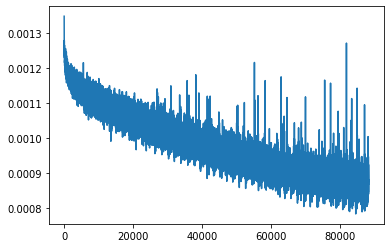

epoch: 48 	 step:0 	 loss: 0.0008209
epoch: 48 	 step:100 	 loss: 0.0008136
epoch: 48 	 step:200 	 loss: 0.0008362
epoch: 48 	 step:300 	 loss: 0.0008696
epoch: 48 	 step:400 	 loss: 0.0008732
epoch: 48 	 step:500 	 loss: 0.0008279
epoch: 48 	 step:600 	 loss: 0.0008586
epoch: 48 	 step:700 	 loss: 0.0008669
epoch: 48 	 step:800 	 loss: 0.0008844
epoch: 48 	 step:900 	 loss: 0.0008433
epoch: 48 	 step:1000 	 loss: 0.0008206
epoch: 48 	 step:1100 	 loss: 0.0008564
epoch: 48 	 step:1200 	 loss: 0.0008282
epoch: 48 	 step:1300 	 loss: 0.0008314
epoch: 48 	 step:1400 	 loss: 0.0008735
epoch: 48 	 step:1500 	 loss: 0.0008422
epoch: 48 	 step:1600 	 loss: 0.0008319
epoch: 48 	 step:1700 	 loss: 0.0008599
epoch: 48 	 step:1800 	 loss: 0.0008553


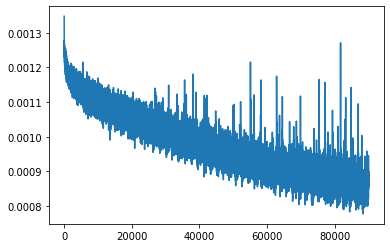

epoch: 49 	 step:0 	 loss: 0.0008245
epoch: 49 	 step:100 	 loss: 0.0007917
epoch: 49 	 step:200 	 loss: 0.0008395
epoch: 49 	 step:300 	 loss: 0.0008521
epoch: 49 	 step:400 	 loss: 0.0008467
epoch: 49 	 step:500 	 loss: 0.0008832
epoch: 49 	 step:600 	 loss: 0.0009004
epoch: 49 	 step:700 	 loss: 0.0008584
epoch: 49 	 step:800 	 loss: 0.0008501
epoch: 49 	 step:900 	 loss: 0.0008459
epoch: 49 	 step:1000 	 loss: 0.0008658
epoch: 49 	 step:1100 	 loss: 0.0008347
epoch: 49 	 step:1200 	 loss: 0.0008554
epoch: 49 	 step:1300 	 loss: 0.0008913
epoch: 49 	 step:1400 	 loss: 0.0009037
epoch: 49 	 step:1500 	 loss: 0.0008946
epoch: 49 	 step:1600 	 loss: 0.0009002
epoch: 49 	 step:1700 	 loss: 0.000873
epoch: 49 	 step:1800 	 loss: 0.000855


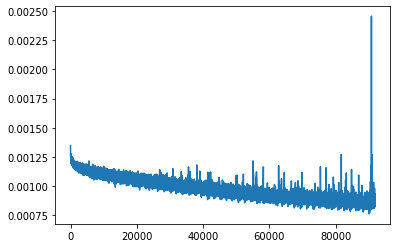

epoch: 50 	 step:0 	 loss: 0.0008624
epoch: 50 	 step:100 	 loss: 0.0007895
epoch: 50 	 step:200 	 loss: 0.0008323
epoch: 50 	 step:300 	 loss: 0.0008229
epoch: 50 	 step:400 	 loss: 0.0008239
epoch: 50 	 step:500 	 loss: 0.0008333
epoch: 50 	 step:600 	 loss: 0.0008231
epoch: 50 	 step:700 	 loss: 0.0008333
epoch: 50 	 step:800 	 loss: 0.0008621
epoch: 50 	 step:900 	 loss: 0.0008718
epoch: 50 	 step:1000 	 loss: 0.0008472
epoch: 50 	 step:1100 	 loss: 0.0008182
epoch: 50 	 step:1200 	 loss: 0.000879
epoch: 50 	 step:1300 	 loss: 0.0009142
epoch: 50 	 step:1400 	 loss: 0.0008629
epoch: 50 	 step:1500 	 loss: 0.0008711
epoch: 50 	 step:1600 	 loss: 0.0008404
epoch: 50 	 step:1700 	 loss: 0.0009126
epoch: 50 	 step:1800 	 loss: 0.0008905


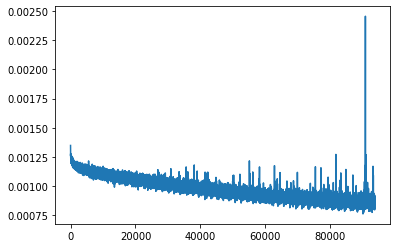

epoch: 51 	 step:0 	 loss: 0.000848
epoch: 51 	 step:100 	 loss: 0.0008292
epoch: 51 	 step:200 	 loss: 0.0008607
epoch: 51 	 step:300 	 loss: 0.000868
epoch: 51 	 step:400 	 loss: 0.0008299
epoch: 51 	 step:500 	 loss: 0.0008333
epoch: 51 	 step:600 	 loss: 0.0008454
epoch: 51 	 step:700 	 loss: 0.0008309
epoch: 51 	 step:800 	 loss: 0.0008193
epoch: 51 	 step:900 	 loss: 0.0008945
epoch: 51 	 step:1000 	 loss: 0.0008431
epoch: 51 	 step:1100 	 loss: 0.0008708
epoch: 51 	 step:1200 	 loss: 0.0008077
epoch: 51 	 step:1300 	 loss: 0.0008618
epoch: 51 	 step:1400 	 loss: 0.0008519
epoch: 51 	 step:1500 	 loss: 0.0008347
epoch: 51 	 step:1600 	 loss: 0.0008099
epoch: 51 	 step:1700 	 loss: 0.0008512
epoch: 51 	 step:1800 	 loss: 0.0008216


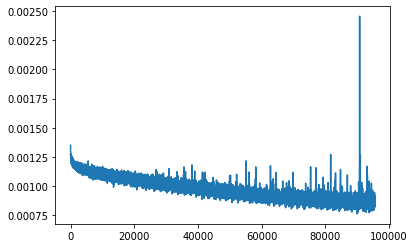

epoch: 52 	 step:0 	 loss: 0.0008622
epoch: 52 	 step:100 	 loss: 0.0008294
epoch: 52 	 step:200 	 loss: 0.0008654
epoch: 52 	 step:300 	 loss: 0.0007981
epoch: 52 	 step:400 	 loss: 0.0008199
epoch: 52 	 step:500 	 loss: 0.0008737
epoch: 52 	 step:600 	 loss: 0.0008217
epoch: 52 	 step:700 	 loss: 0.0008542
epoch: 52 	 step:800 	 loss: 0.0008422
epoch: 52 	 step:900 	 loss: 0.0008305
epoch: 52 	 step:1000 	 loss: 0.0008355
epoch: 52 	 step:1100 	 loss: 0.0008396
epoch: 52 	 step:1200 	 loss: 0.0008314
epoch: 52 	 step:1300 	 loss: 0.0008733
epoch: 52 	 step:1400 	 loss: 0.0008443
epoch: 52 	 step:1500 	 loss: 0.0008689
epoch: 52 	 step:1600 	 loss: 0.0008406
epoch: 52 	 step:1700 	 loss: 0.0008221
epoch: 52 	 step:1800 	 loss: 0.0008271


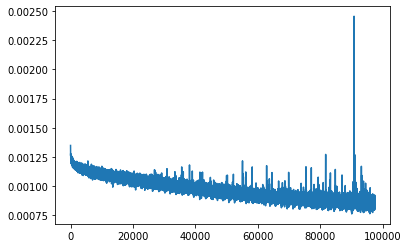

epoch: 53 	 step:0 	 loss: 0.0008563
epoch: 53 	 step:100 	 loss: 0.0008329
epoch: 53 	 step:200 	 loss: 0.0008206
epoch: 53 	 step:300 	 loss: 0.0008456
epoch: 53 	 step:400 	 loss: 0.0008041
epoch: 53 	 step:500 	 loss: 0.0008355
epoch: 53 	 step:600 	 loss: 0.0008076
epoch: 53 	 step:700 	 loss: 0.0008426
epoch: 53 	 step:800 	 loss: 0.0008241
epoch: 53 	 step:900 	 loss: 0.0007939
epoch: 53 	 step:1000 	 loss: 0.0008124
epoch: 53 	 step:1100 	 loss: 0.0008621
epoch: 53 	 step:1200 	 loss: 0.0008067
epoch: 53 	 step:1300 	 loss: 0.0008585
epoch: 53 	 step:1400 	 loss: 0.0008351
epoch: 53 	 step:1500 	 loss: 0.0008388
epoch: 53 	 step:1600 	 loss: 0.0008227
epoch: 53 	 step:1700 	 loss: 0.0008601
epoch: 53 	 step:1800 	 loss: 0.0008331


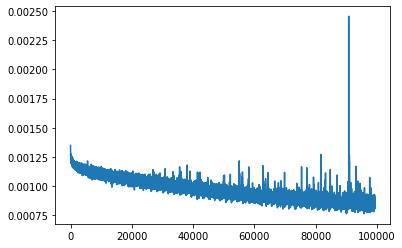

epoch: 54 	 step:0 	 loss: 0.0008749
epoch: 54 	 step:100 	 loss: 0.0007875
epoch: 54 	 step:200 	 loss: 0.0008011
epoch: 54 	 step:300 	 loss: 0.0008041
epoch: 54 	 step:400 	 loss: 0.0007782
epoch: 54 	 step:500 	 loss: 0.000822
epoch: 54 	 step:600 	 loss: 0.0008495
epoch: 54 	 step:700 	 loss: 0.0008177
epoch: 54 	 step:800 	 loss: 0.0008349
epoch: 54 	 step:900 	 loss: 0.0008071
epoch: 54 	 step:1000 	 loss: 0.0008233
epoch: 54 	 step:1100 	 loss: 0.0008065
epoch: 54 	 step:1200 	 loss: 0.0008637
epoch: 54 	 step:1300 	 loss: 0.0008198
epoch: 54 	 step:1400 	 loss: 0.0008333
epoch: 54 	 step:1500 	 loss: 0.0008554
epoch: 54 	 step:1600 	 loss: 0.0008122
epoch: 54 	 step:1700 	 loss: 0.0008563
epoch: 54 	 step:1800 	 loss: 0.0008347


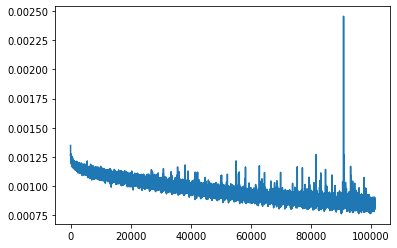

epoch: 55 	 step:0 	 loss: 0.000846
epoch: 55 	 step:100 	 loss: 0.0008071
epoch: 55 	 step:200 	 loss: 0.000807
epoch: 55 	 step:300 	 loss: 0.0008094
epoch: 55 	 step:400 	 loss: 0.0008006
epoch: 55 	 step:500 	 loss: 0.0008299
epoch: 55 	 step:600 	 loss: 0.0008084
epoch: 55 	 step:700 	 loss: 0.0008338
epoch: 55 	 step:800 	 loss: 0.0008414
epoch: 55 	 step:900 	 loss: 0.0008506
epoch: 55 	 step:1000 	 loss: 0.0008246
epoch: 55 	 step:1100 	 loss: 0.0008311
epoch: 55 	 step:1200 	 loss: 0.0008398
epoch: 55 	 step:1300 	 loss: 0.0008274
epoch: 55 	 step:1400 	 loss: 0.0008341
epoch: 55 	 step:1500 	 loss: 0.0008528
epoch: 55 	 step:1600 	 loss: 0.0008467
epoch: 55 	 step:1700 	 loss: 0.0008926
epoch: 55 	 step:1800 	 loss: 0.0008427


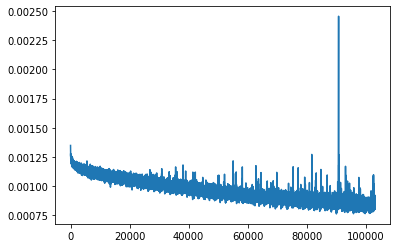

epoch: 56 	 step:0 	 loss: 0.0008109
epoch: 56 	 step:100 	 loss: 0.0008147
epoch: 56 	 step:200 	 loss: 0.0008194
epoch: 56 	 step:300 	 loss: 0.0007924
epoch: 56 	 step:400 	 loss: 0.0008169
epoch: 56 	 step:500 	 loss: 0.0008182
epoch: 56 	 step:600 	 loss: 0.0008365
epoch: 56 	 step:700 	 loss: 0.0008741
epoch: 56 	 step:800 	 loss: 0.0007929
epoch: 56 	 step:900 	 loss: 0.0008381
epoch: 56 	 step:1000 	 loss: 0.000847
epoch: 56 	 step:1100 	 loss: 0.0008652
epoch: 56 	 step:1200 	 loss: 0.0008507
epoch: 56 	 step:1300 	 loss: 0.0008784
epoch: 56 	 step:1400 	 loss: 0.0008214
epoch: 56 	 step:1500 	 loss: 0.0008737
epoch: 56 	 step:1600 	 loss: 0.000823
epoch: 56 	 step:1700 	 loss: 0.0008501
epoch: 56 	 step:1800 	 loss: 0.0008202


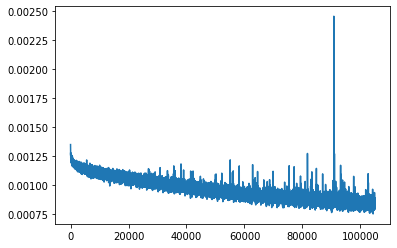

epoch: 57 	 step:0 	 loss: 0.0008278
epoch: 57 	 step:100 	 loss: 0.0007777
epoch: 57 	 step:200 	 loss: 0.0008345
epoch: 57 	 step:300 	 loss: 0.0008523
epoch: 57 	 step:400 	 loss: 0.0007951
epoch: 57 	 step:500 	 loss: 0.0008513
epoch: 57 	 step:600 	 loss: 0.0008266
epoch: 57 	 step:700 	 loss: 0.0008024
epoch: 57 	 step:800 	 loss: 0.0008131
epoch: 57 	 step:900 	 loss: 0.0007841
epoch: 57 	 step:1000 	 loss: 0.0008237
epoch: 57 	 step:1100 	 loss: 0.0008008
epoch: 57 	 step:1200 	 loss: 0.0008147
epoch: 57 	 step:1300 	 loss: 0.0008208
epoch: 57 	 step:1400 	 loss: 0.0008384
epoch: 57 	 step:1500 	 loss: 0.0008539
epoch: 57 	 step:1600 	 loss: 0.0008449
epoch: 57 	 step:1700 	 loss: 0.0008692
epoch: 57 	 step:1800 	 loss: 0.0008155


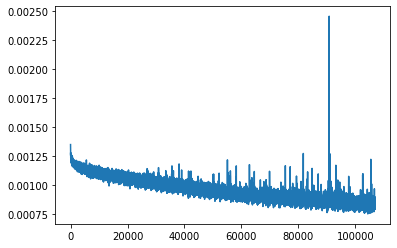

epoch: 58 	 step:0 	 loss: 0.0008175
epoch: 58 	 step:100 	 loss: 0.0008178
epoch: 58 	 step:200 	 loss: 0.0008019
epoch: 58 	 step:300 	 loss: 0.0008271
epoch: 58 	 step:400 	 loss: 0.0007827
epoch: 58 	 step:500 	 loss: 0.0008297
epoch: 58 	 step:600 	 loss: 0.0007919
epoch: 58 	 step:700 	 loss: 0.0007966
epoch: 58 	 step:800 	 loss: 0.0008315
epoch: 58 	 step:900 	 loss: 0.0008281
epoch: 58 	 step:1000 	 loss: 0.0008278
epoch: 58 	 step:1100 	 loss: 0.0008036
epoch: 58 	 step:1200 	 loss: 0.0008485
epoch: 58 	 step:1300 	 loss: 0.0008389
epoch: 58 	 step:1400 	 loss: 0.0008272
epoch: 58 	 step:1500 	 loss: 0.0008587
epoch: 58 	 step:1600 	 loss: 0.0008119
epoch: 58 	 step:1700 	 loss: 0.0008187
epoch: 58 	 step:1800 	 loss: 0.0008863


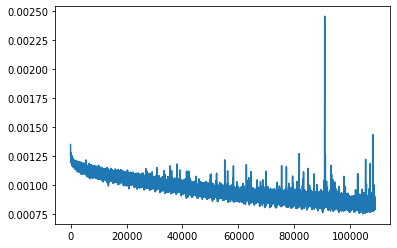

epoch: 59 	 step:0 	 loss: 0.0007827
epoch: 59 	 step:100 	 loss: 0.0008267
epoch: 59 	 step:200 	 loss: 0.0008313
epoch: 59 	 step:300 	 loss: 0.0007788
epoch: 59 	 step:400 	 loss: 0.000805
epoch: 59 	 step:500 	 loss: 0.0008386
epoch: 59 	 step:600 	 loss: 0.0008032
epoch: 59 	 step:700 	 loss: 0.0008467
epoch: 59 	 step:800 	 loss: 0.000864
epoch: 59 	 step:900 	 loss: 0.0008338
epoch: 59 	 step:1000 	 loss: 0.0007878
epoch: 59 	 step:1100 	 loss: 0.0007989
epoch: 59 	 step:1200 	 loss: 0.0008169
epoch: 59 	 step:1300 	 loss: 0.0008217
epoch: 59 	 step:1400 	 loss: 0.0008115
epoch: 59 	 step:1500 	 loss: 0.0008859
epoch: 59 	 step:1600 	 loss: 0.0007986
epoch: 59 	 step:1700 	 loss: 0.0008088
epoch: 59 	 step:1800 	 loss: 0.000823


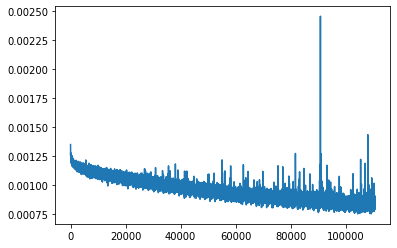

epoch: 60 	 step:0 	 loss: 0.0008014
epoch: 60 	 step:100 	 loss: 0.0007767
epoch: 60 	 step:200 	 loss: 0.0007854
epoch: 60 	 step:300 	 loss: 0.0008201
epoch: 60 	 step:400 	 loss: 0.0008457
epoch: 60 	 step:500 	 loss: 0.0007846
epoch: 60 	 step:600 	 loss: 0.0008084
epoch: 60 	 step:700 	 loss: 0.0007673
epoch: 60 	 step:800 	 loss: 0.0008357
epoch: 60 	 step:900 	 loss: 0.0008447
epoch: 60 	 step:1000 	 loss: 0.0007773
epoch: 60 	 step:1100 	 loss: 0.0008521
epoch: 60 	 step:1200 	 loss: 0.0008144
epoch: 60 	 step:1300 	 loss: 0.0008175
epoch: 60 	 step:1400 	 loss: 0.0008259
epoch: 60 	 step:1500 	 loss: 0.0008134
epoch: 60 	 step:1600 	 loss: 0.000857
epoch: 60 	 step:1700 	 loss: 0.0008167
epoch: 60 	 step:1800 	 loss: 0.0008202


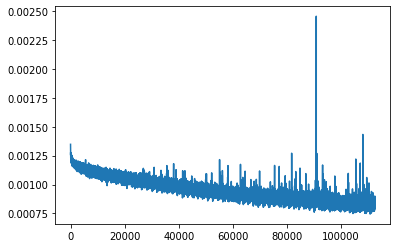

epoch: 61 	 step:0 	 loss: 0.000806
epoch: 61 	 step:100 	 loss: 0.0007989
epoch: 61 	 step:200 	 loss: 0.000783
epoch: 61 	 step:300 	 loss: 0.000794
epoch: 61 	 step:400 	 loss: 0.000791
epoch: 61 	 step:500 	 loss: 0.0008219
epoch: 61 	 step:600 	 loss: 0.0008273
epoch: 61 	 step:700 	 loss: 0.0007972
epoch: 61 	 step:800 	 loss: 0.000816
epoch: 61 	 step:900 	 loss: 0.0008196
epoch: 61 	 step:1000 	 loss: 0.0007859
epoch: 61 	 step:1100 	 loss: 0.0008455
epoch: 61 	 step:1200 	 loss: 0.0008004
epoch: 61 	 step:1300 	 loss: 0.0008018
epoch: 61 	 step:1400 	 loss: 0.0007986
epoch: 61 	 step:1500 	 loss: 0.0008104
epoch: 61 	 step:1600 	 loss: 0.0008119
epoch: 61 	 step:1700 	 loss: 0.0008308
epoch: 61 	 step:1800 	 loss: 0.0007923


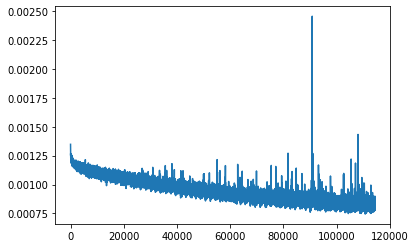

epoch: 62 	 step:0 	 loss: 0.0008325
epoch: 62 	 step:100 	 loss: 0.0007843
epoch: 62 	 step:200 	 loss: 0.0007574
epoch: 62 	 step:300 	 loss: 0.0007972
epoch: 62 	 step:400 	 loss: 0.0007931
epoch: 62 	 step:500 	 loss: 0.0007987
epoch: 62 	 step:600 	 loss: 0.0008421
epoch: 62 	 step:700 	 loss: 0.0008169
epoch: 62 	 step:800 	 loss: 0.0007977
epoch: 62 	 step:900 	 loss: 0.0008454
epoch: 62 	 step:1000 	 loss: 0.0007902
epoch: 62 	 step:1100 	 loss: 0.0008417
epoch: 62 	 step:1200 	 loss: 0.0008062
epoch: 62 	 step:1300 	 loss: 0.0008037
epoch: 62 	 step:1400 	 loss: 0.0008471
epoch: 62 	 step:1500 	 loss: 0.0008205
epoch: 62 	 step:1600 	 loss: 0.0008184
epoch: 62 	 step:1700 	 loss: 0.0008388
epoch: 62 	 step:1800 	 loss: 0.0008181


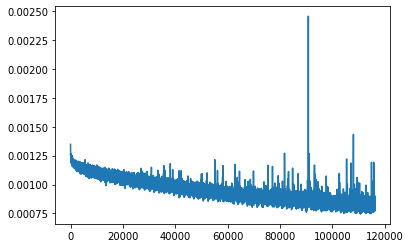

epoch: 63 	 step:0 	 loss: 0.000806
epoch: 63 	 step:100 	 loss: 0.0007771
epoch: 63 	 step:200 	 loss: 0.0007745
epoch: 63 	 step:300 	 loss: 0.0008118
epoch: 63 	 step:400 	 loss: 0.0008518
epoch: 63 	 step:500 	 loss: 0.0008143
epoch: 63 	 step:600 	 loss: 0.0008015
epoch: 63 	 step:700 	 loss: 0.0008206
epoch: 63 	 step:800 	 loss: 0.0008127
epoch: 63 	 step:900 	 loss: 0.0008103
epoch: 63 	 step:1000 	 loss: 0.000806
epoch: 63 	 step:1100 	 loss: 0.0008451
epoch: 63 	 step:1200 	 loss: 0.0008366
epoch: 63 	 step:1300 	 loss: 0.0008331
epoch: 63 	 step:1400 	 loss: 0.0008427
epoch: 63 	 step:1500 	 loss: 0.0008244
epoch: 63 	 step:1600 	 loss: 0.0008126
epoch: 63 	 step:1700 	 loss: 0.0007974
epoch: 63 	 step:1800 	 loss: 0.0007973


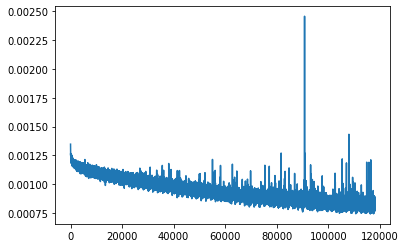

epoch: 64 	 step:0 	 loss: 0.0008082
epoch: 64 	 step:100 	 loss: 0.0007884
epoch: 64 	 step:200 	 loss: 0.0008259
epoch: 64 	 step:300 	 loss: 0.0007873
epoch: 64 	 step:400 	 loss: 0.0007761
epoch: 64 	 step:500 	 loss: 0.0008073
epoch: 64 	 step:600 	 loss: 0.0007992
epoch: 64 	 step:700 	 loss: 0.000827
epoch: 64 	 step:800 	 loss: 0.0008449
epoch: 64 	 step:900 	 loss: 0.0008622
epoch: 64 	 step:1000 	 loss: 0.0008489
epoch: 64 	 step:1100 	 loss: 0.0008226
epoch: 64 	 step:1200 	 loss: 0.0008047
epoch: 64 	 step:1300 	 loss: 0.0008167
epoch: 64 	 step:1400 	 loss: 0.0007905
epoch: 64 	 step:1500 	 loss: 0.0008242
epoch: 64 	 step:1600 	 loss: 0.0007978
epoch: 64 	 step:1700 	 loss: 0.0007966
epoch: 64 	 step:1800 	 loss: 0.0008166


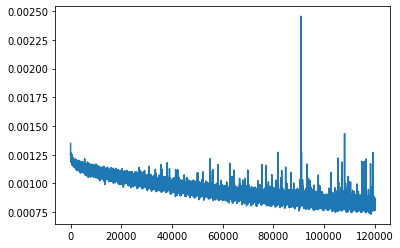

epoch: 65 	 step:0 	 loss: 0.0007935
epoch: 65 	 step:100 	 loss: 0.0008082
epoch: 65 	 step:200 	 loss: 0.0008411
epoch: 65 	 step:300 	 loss: 0.0008006
epoch: 65 	 step:400 	 loss: 0.0008446
epoch: 65 	 step:500 	 loss: 0.0008308
epoch: 65 	 step:600 	 loss: 0.0007789
epoch: 65 	 step:700 	 loss: 0.0008117
epoch: 65 	 step:800 	 loss: 0.0007693
epoch: 65 	 step:900 	 loss: 0.0008248
epoch: 65 	 step:1000 	 loss: 0.0008177
epoch: 65 	 step:1100 	 loss: 0.0007938
epoch: 65 	 step:1200 	 loss: 0.0007719
epoch: 65 	 step:1300 	 loss: 0.0007971
epoch: 65 	 step:1400 	 loss: 0.0008043
epoch: 65 	 step:1500 	 loss: 0.0008281
epoch: 65 	 step:1600 	 loss: 0.0007608
epoch: 65 	 step:1700 	 loss: 0.0008266
epoch: 65 	 step:1800 	 loss: 0.0008578


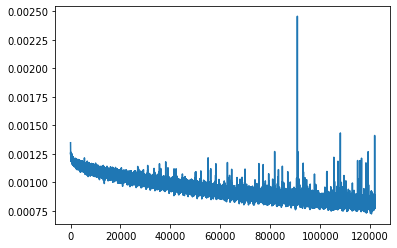

epoch: 66 	 step:0 	 loss: 0.0008083
epoch: 66 	 step:100 	 loss: 0.0008144
epoch: 66 	 step:200 	 loss: 0.0008061
epoch: 66 	 step:300 	 loss: 0.0007802
epoch: 66 	 step:400 	 loss: 0.0007871
epoch: 66 	 step:500 	 loss: 0.0007684
epoch: 66 	 step:600 	 loss: 0.0008373
epoch: 66 	 step:700 	 loss: 0.0008319
epoch: 66 	 step:800 	 loss: 0.0008499
epoch: 66 	 step:900 	 loss: 0.0007627
epoch: 66 	 step:1000 	 loss: 0.0007949
epoch: 66 	 step:1100 	 loss: 0.000823
epoch: 66 	 step:1200 	 loss: 0.0008025
epoch: 66 	 step:1300 	 loss: 0.0008318
epoch: 66 	 step:1400 	 loss: 0.0008346
epoch: 66 	 step:1500 	 loss: 0.0008624
epoch: 66 	 step:1600 	 loss: 0.000811
epoch: 66 	 step:1700 	 loss: 0.000814
epoch: 66 	 step:1800 	 loss: 0.0008293


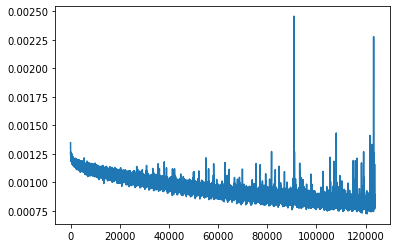

epoch: 67 	 step:0 	 loss: 0.0007573
epoch: 67 	 step:100 	 loss: 0.0007642
epoch: 67 	 step:200 	 loss: 0.0008339
epoch: 67 	 step:300 	 loss: 0.0008492
epoch: 67 	 step:400 	 loss: 0.0007793
epoch: 67 	 step:500 	 loss: 0.0008122
epoch: 67 	 step:600 	 loss: 0.0008037
epoch: 67 	 step:700 	 loss: 0.0007764
epoch: 67 	 step:800 	 loss: 0.0007872
epoch: 67 	 step:900 	 loss: 0.0008432
epoch: 67 	 step:1000 	 loss: 0.0008139
epoch: 67 	 step:1100 	 loss: 0.000832
epoch: 67 	 step:1200 	 loss: 0.0008228
epoch: 67 	 step:1300 	 loss: 0.0007815
epoch: 67 	 step:1400 	 loss: 0.0008226
epoch: 67 	 step:1500 	 loss: 0.0008249
epoch: 67 	 step:1600 	 loss: 0.0008454
epoch: 67 	 step:1700 	 loss: 0.0008256
epoch: 67 	 step:1800 	 loss: 0.0007978


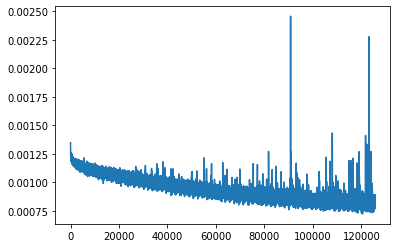

epoch: 68 	 step:0 	 loss: 0.000786
epoch: 68 	 step:100 	 loss: 0.0007682
epoch: 68 	 step:200 	 loss: 0.0008213
epoch: 68 	 step:300 	 loss: 0.0007594
epoch: 68 	 step:400 	 loss: 0.0008254
epoch: 68 	 step:500 	 loss: 0.0007934
epoch: 68 	 step:600 	 loss: 0.0008039
epoch: 68 	 step:700 	 loss: 0.0007841
epoch: 68 	 step:800 	 loss: 0.0007854
epoch: 68 	 step:900 	 loss: 0.0007963
epoch: 68 	 step:1000 	 loss: 0.0008005
epoch: 68 	 step:1100 	 loss: 0.0008237
epoch: 68 	 step:1200 	 loss: 0.0007963
epoch: 68 	 step:1300 	 loss: 0.0008117
epoch: 68 	 step:1400 	 loss: 0.0008069
epoch: 68 	 step:1500 	 loss: 0.0007942
epoch: 68 	 step:1600 	 loss: 0.0008214
epoch: 68 	 step:1700 	 loss: 0.0007942
epoch: 68 	 step:1800 	 loss: 0.0008204


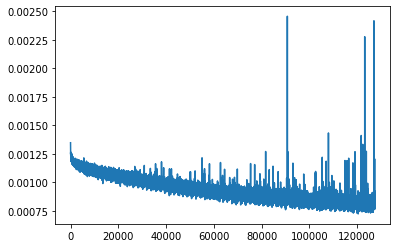

epoch: 69 	 step:0 	 loss: 0.0007665
epoch: 69 	 step:100 	 loss: 0.0007741
epoch: 69 	 step:200 	 loss: 0.0007884
epoch: 69 	 step:300 	 loss: 0.0007725
epoch: 69 	 step:400 	 loss: 0.0008192
epoch: 69 	 step:500 	 loss: 0.0007846
epoch: 69 	 step:600 	 loss: 0.0007861
epoch: 69 	 step:700 	 loss: 0.0008244
epoch: 69 	 step:800 	 loss: 0.0007788
epoch: 69 	 step:900 	 loss: 0.0008192
epoch: 69 	 step:1000 	 loss: 0.0007962
epoch: 69 	 step:1100 	 loss: 0.0007892
epoch: 69 	 step:1200 	 loss: 0.0008218
epoch: 69 	 step:1300 	 loss: 0.0008375
epoch: 69 	 step:1400 	 loss: 0.000778
epoch: 69 	 step:1500 	 loss: 0.000802
epoch: 69 	 step:1600 	 loss: 0.0007924
epoch: 69 	 step:1700 	 loss: 0.0008206
epoch: 69 	 step:1800 	 loss: 0.0008221


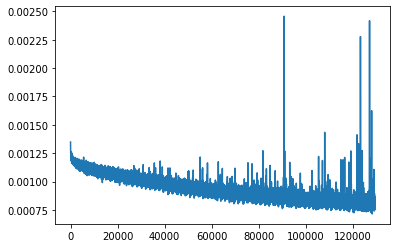

epoch: 70 	 step:0 	 loss: 0.0007649
epoch: 70 	 step:100 	 loss: 0.0007947
epoch: 70 	 step:200 	 loss: 0.0007956
epoch: 70 	 step:300 	 loss: 0.0008022
epoch: 70 	 step:400 	 loss: 0.0007727
epoch: 70 	 step:500 	 loss: 0.0007991
epoch: 70 	 step:600 	 loss: 0.0007862
epoch: 70 	 step:700 	 loss: 0.0007708
epoch: 70 	 step:800 	 loss: 0.0008008
epoch: 70 	 step:900 	 loss: 0.0007709
epoch: 70 	 step:1000 	 loss: 0.0007926
epoch: 70 	 step:1100 	 loss: 0.0008043
epoch: 70 	 step:1200 	 loss: 0.0008661
epoch: 70 	 step:1300 	 loss: 0.0007901
epoch: 70 	 step:1400 	 loss: 0.0008004
epoch: 70 	 step:1500 	 loss: 0.0007972
epoch: 70 	 step:1600 	 loss: 0.0007868
epoch: 70 	 step:1700 	 loss: 0.0007755
epoch: 70 	 step:1800 	 loss: 0.0007816


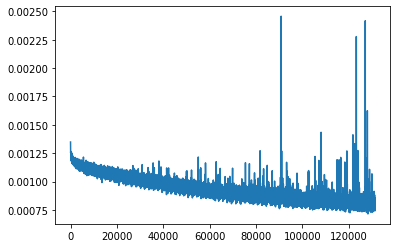

epoch: 71 	 step:0 	 loss: 0.0007623
epoch: 71 	 step:100 	 loss: 0.0008021
epoch: 71 	 step:200 	 loss: 0.0007597
epoch: 71 	 step:300 	 loss: 0.0007733
epoch: 71 	 step:400 	 loss: 0.000762
epoch: 71 	 step:500 	 loss: 0.0007805
epoch: 71 	 step:600 	 loss: 0.0007588
epoch: 71 	 step:700 	 loss: 0.0007529
epoch: 71 	 step:800 	 loss: 0.0007949
epoch: 71 	 step:900 	 loss: 0.0008256
epoch: 71 	 step:1000 	 loss: 0.0007957
epoch: 71 	 step:1100 	 loss: 0.0007754
epoch: 71 	 step:1200 	 loss: 0.0007793
epoch: 71 	 step:1300 	 loss: 0.0008291
epoch: 71 	 step:1400 	 loss: 0.0007991
epoch: 71 	 step:1500 	 loss: 0.0007903
epoch: 71 	 step:1600 	 loss: 0.000788
epoch: 71 	 step:1700 	 loss: 0.0008042
epoch: 71 	 step:1800 	 loss: 0.000779


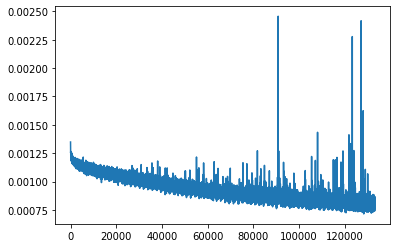

epoch: 72 	 step:0 	 loss: 0.0007931
epoch: 72 	 step:100 	 loss: 0.0007989
epoch: 72 	 step:200 	 loss: 0.0008186
epoch: 72 	 step:300 	 loss: 0.0008133
epoch: 72 	 step:400 	 loss: 0.0008026
epoch: 72 	 step:500 	 loss: 0.0007485
epoch: 72 	 step:600 	 loss: 0.0008577
epoch: 72 	 step:700 	 loss: 0.0008012
epoch: 72 	 step:800 	 loss: 0.0007958
epoch: 72 	 step:900 	 loss: 0.0008078
epoch: 72 	 step:1000 	 loss: 0.0007993
epoch: 72 	 step:1100 	 loss: 0.0007923
epoch: 72 	 step:1200 	 loss: 0.0008047
epoch: 72 	 step:1300 	 loss: 0.0007847
epoch: 72 	 step:1400 	 loss: 0.0007737
epoch: 72 	 step:1500 	 loss: 0.0008014
epoch: 72 	 step:1600 	 loss: 0.0007942
epoch: 72 	 step:1700 	 loss: 0.0008096
epoch: 72 	 step:1800 	 loss: 0.0008217


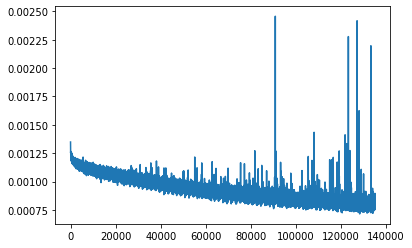

epoch: 73 	 step:0 	 loss: 0.000713
epoch: 73 	 step:100 	 loss: 0.0007755
epoch: 73 	 step:200 	 loss: 0.0007546
epoch: 73 	 step:300 	 loss: 0.0007377
epoch: 73 	 step:400 	 loss: 0.0007716
epoch: 73 	 step:500 	 loss: 0.0007692
epoch: 73 	 step:600 	 loss: 0.0007798
epoch: 73 	 step:700 	 loss: 0.0008205
epoch: 73 	 step:800 	 loss: 0.0008025
epoch: 73 	 step:900 	 loss: 0.000813
epoch: 73 	 step:1000 	 loss: 0.0007847
epoch: 73 	 step:1100 	 loss: 0.0007958
epoch: 73 	 step:1200 	 loss: 0.0007939
epoch: 73 	 step:1300 	 loss: 0.0007813
epoch: 73 	 step:1400 	 loss: 0.0008241
epoch: 73 	 step:1500 	 loss: 0.0008415
epoch: 73 	 step:1600 	 loss: 0.0008294
epoch: 73 	 step:1700 	 loss: 0.0007889
epoch: 73 	 step:1800 	 loss: 0.0007982


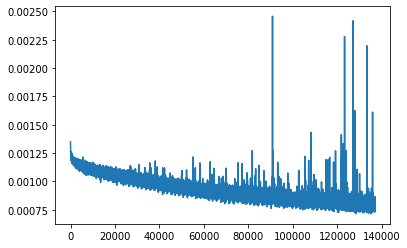

epoch: 74 	 step:0 	 loss: 0.0007789
epoch: 74 	 step:100 	 loss: 0.0007622
epoch: 74 	 step:200 	 loss: 0.0008262
epoch: 74 	 step:300 	 loss: 0.0008018
epoch: 74 	 step:400 	 loss: 0.0008017
epoch: 74 	 step:500 	 loss: 0.0008023
epoch: 74 	 step:600 	 loss: 0.0008571
epoch: 74 	 step:700 	 loss: 0.0007779
epoch: 74 	 step:800 	 loss: 0.0008425
epoch: 74 	 step:900 	 loss: 0.0007696
epoch: 74 	 step:1000 	 loss: 0.0007381
epoch: 74 	 step:1100 	 loss: 0.0008001
epoch: 74 	 step:1200 	 loss: 0.0007962
epoch: 74 	 step:1300 	 loss: 0.0008024
epoch: 74 	 step:1400 	 loss: 0.0007931
epoch: 74 	 step:1500 	 loss: 0.0008093
epoch: 74 	 step:1600 	 loss: 0.0008838
epoch: 74 	 step:1700 	 loss: 0.0007942
epoch: 74 	 step:1800 	 loss: 0.0008033


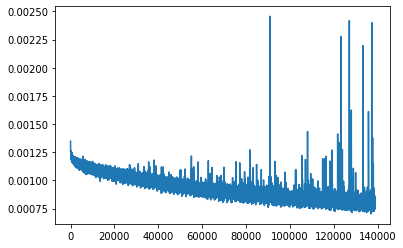

epoch: 75 	 step:0 	 loss: 0.0007814
epoch: 75 	 step:100 	 loss: 0.0007775
epoch: 75 	 step:200 	 loss: 0.000764
epoch: 75 	 step:300 	 loss: 0.0008234
epoch: 75 	 step:400 	 loss: 0.0007944
epoch: 75 	 step:500 	 loss: 0.0007596
epoch: 75 	 step:600 	 loss: 0.0007697
epoch: 75 	 step:700 	 loss: 0.0008003
epoch: 75 	 step:800 	 loss: 0.0007681
epoch: 75 	 step:900 	 loss: 0.0007912
epoch: 75 	 step:1000 	 loss: 0.0008067
epoch: 75 	 step:1100 	 loss: 0.0007746
epoch: 75 	 step:1200 	 loss: 0.0007891
epoch: 75 	 step:1300 	 loss: 0.0007965
epoch: 75 	 step:1400 	 loss: 0.0008076
epoch: 75 	 step:1500 	 loss: 0.0007938
epoch: 75 	 step:1600 	 loss: 0.0008024
epoch: 75 	 step:1700 	 loss: 0.0008133
epoch: 75 	 step:1800 	 loss: 0.0007644


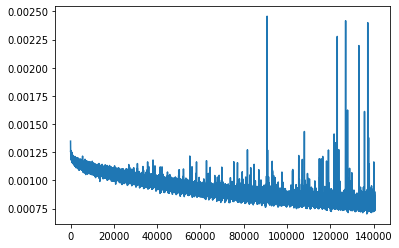

epoch: 76 	 step:0 	 loss: 0.0007579
epoch: 76 	 step:100 	 loss: 0.000778
epoch: 76 	 step:200 	 loss: 0.0007387
epoch: 76 	 step:300 	 loss: 0.0007783
epoch: 76 	 step:400 	 loss: 0.0007473
epoch: 76 	 step:500 	 loss: 0.000785
epoch: 76 	 step:600 	 loss: 0.0007885
epoch: 76 	 step:700 	 loss: 0.0007989
epoch: 76 	 step:800 	 loss: 0.0007709
epoch: 76 	 step:900 	 loss: 0.0007876
epoch: 76 	 step:1000 	 loss: 0.000788
epoch: 76 	 step:1100 	 loss: 0.0007905
epoch: 76 	 step:1200 	 loss: 0.0007753
epoch: 76 	 step:1300 	 loss: 0.0007945
epoch: 76 	 step:1400 	 loss: 0.0007656
epoch: 76 	 step:1500 	 loss: 0.0008131
epoch: 76 	 step:1600 	 loss: 0.0007923
epoch: 76 	 step:1700 	 loss: 0.0008365
epoch: 76 	 step:1800 	 loss: 0.000786


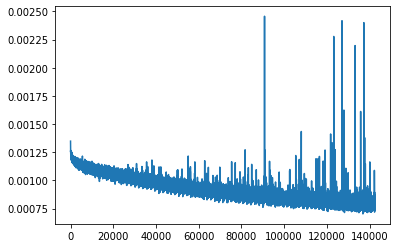

epoch: 77 	 step:0 	 loss: 0.0007453
epoch: 77 	 step:100 	 loss: 0.0007118
epoch: 77 	 step:200 	 loss: 0.000734
epoch: 77 	 step:300 	 loss: 0.0008025
epoch: 77 	 step:400 	 loss: 0.0007929
epoch: 77 	 step:500 	 loss: 0.0007612
epoch: 77 	 step:600 	 loss: 0.0007648
epoch: 77 	 step:700 	 loss: 0.0007828
epoch: 77 	 step:800 	 loss: 0.0007916
epoch: 77 	 step:900 	 loss: 0.0007466
epoch: 77 	 step:1000 	 loss: 0.0007901
epoch: 77 	 step:1100 	 loss: 0.000739
epoch: 77 	 step:1200 	 loss: 0.0007378
epoch: 77 	 step:1300 	 loss: 0.0007968
epoch: 77 	 step:1400 	 loss: 0.0007849
epoch: 77 	 step:1500 	 loss: 0.0007981
epoch: 77 	 step:1600 	 loss: 0.0007904
epoch: 77 	 step:1700 	 loss: 0.0008145
epoch: 77 	 step:1800 	 loss: 0.0008138


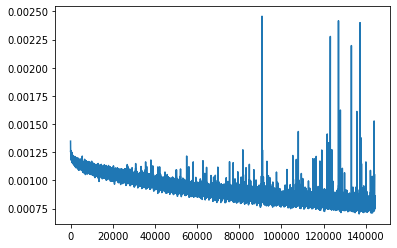

epoch: 78 	 step:0 	 loss: 0.000746
epoch: 78 	 step:100 	 loss: 0.0007905
epoch: 78 	 step:200 	 loss: 0.0007779
epoch: 78 	 step:300 	 loss: 0.0007372
epoch: 78 	 step:400 	 loss: 0.0007703
epoch: 78 	 step:500 	 loss: 0.0007936
epoch: 78 	 step:600 	 loss: 0.0007923
epoch: 78 	 step:700 	 loss: 0.0007909
epoch: 78 	 step:800 	 loss: 0.0007531
epoch: 78 	 step:900 	 loss: 0.0007468
epoch: 78 	 step:1000 	 loss: 0.0007757
epoch: 78 	 step:1100 	 loss: 0.0007723
epoch: 78 	 step:1200 	 loss: 0.0007846
epoch: 78 	 step:1300 	 loss: 0.0008194
epoch: 78 	 step:1400 	 loss: 0.0008354
epoch: 78 	 step:1500 	 loss: 0.0008115
epoch: 78 	 step:1600 	 loss: 0.0007597
epoch: 78 	 step:1700 	 loss: 0.000766
epoch: 78 	 step:1800 	 loss: 0.0008275


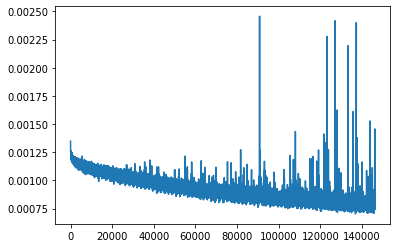

epoch: 79 	 step:0 	 loss: 0.0007752
epoch: 79 	 step:100 	 loss: 0.0008331
epoch: 79 	 step:200 	 loss: 0.0007685
epoch: 79 	 step:300 	 loss: 0.0007577
epoch: 79 	 step:400 	 loss: 0.0007669
epoch: 79 	 step:500 	 loss: 0.0008338
epoch: 79 	 step:600 	 loss: 0.0007625
epoch: 79 	 step:700 	 loss: 0.0007556
epoch: 79 	 step:800 	 loss: 0.000778
epoch: 79 	 step:900 	 loss: 0.0008011
epoch: 79 	 step:1000 	 loss: 0.0008117
epoch: 79 	 step:1100 	 loss: 0.000784
epoch: 79 	 step:1200 	 loss: 0.0007877
epoch: 79 	 step:1300 	 loss: 0.0007613
epoch: 79 	 step:1400 	 loss: 0.0007752
epoch: 79 	 step:1500 	 loss: 0.0007903
epoch: 79 	 step:1600 	 loss: 0.0008064
epoch: 79 	 step:1700 	 loss: 0.0008012
epoch: 79 	 step:1800 	 loss: 0.0007546


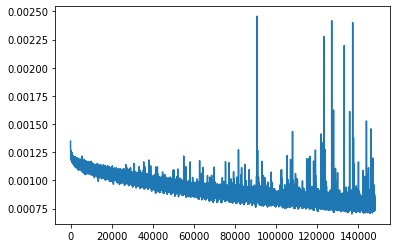

epoch: 80 	 step:0 	 loss: 0.0007279
epoch: 80 	 step:100 	 loss: 0.000765
epoch: 80 	 step:200 	 loss: 0.000775
epoch: 80 	 step:300 	 loss: 0.0007383
epoch: 80 	 step:400 	 loss: 0.0007783
epoch: 80 	 step:500 	 loss: 0.0007931
epoch: 80 	 step:600 	 loss: 0.0007559
epoch: 80 	 step:700 	 loss: 0.0008214
epoch: 80 	 step:800 	 loss: 0.0008128
epoch: 80 	 step:900 	 loss: 0.0008079
epoch: 80 	 step:1000 	 loss: 0.0007629
epoch: 80 	 step:1100 	 loss: 0.0007668
epoch: 80 	 step:1200 	 loss: 0.0007771
epoch: 80 	 step:1300 	 loss: 0.0007457
epoch: 80 	 step:1400 	 loss: 0.0007643
epoch: 80 	 step:1500 	 loss: 0.0008345
epoch: 80 	 step:1600 	 loss: 0.0007773
epoch: 80 	 step:1700 	 loss: 0.0007955
epoch: 80 	 step:1800 	 loss: 0.0008017


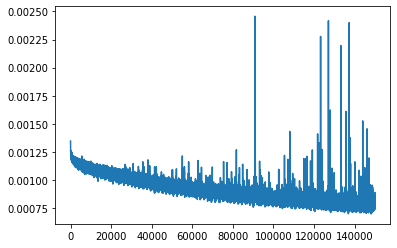

epoch: 81 	 step:0 	 loss: 0.0007232
epoch: 81 	 step:100 	 loss: 0.0007431
epoch: 81 	 step:200 	 loss: 0.0007711
epoch: 81 	 step:300 	 loss: 0.0007386
epoch: 81 	 step:400 	 loss: 0.0008022
epoch: 81 	 step:500 	 loss: 0.0007841
epoch: 81 	 step:600 	 loss: 0.0007648
epoch: 81 	 step:700 	 loss: 0.0007951
epoch: 81 	 step:800 	 loss: 0.0007731
epoch: 81 	 step:900 	 loss: 0.0007885
epoch: 81 	 step:1000 	 loss: 0.0007531
epoch: 81 	 step:1100 	 loss: 0.0007797
epoch: 81 	 step:1200 	 loss: 0.0007841
epoch: 81 	 step:1300 	 loss: 0.0007724
epoch: 81 	 step:1400 	 loss: 0.0007547
epoch: 81 	 step:1500 	 loss: 0.0007847
epoch: 81 	 step:1600 	 loss: 0.0007504
epoch: 81 	 step:1700 	 loss: 0.000802
epoch: 81 	 step:1800 	 loss: 0.0008002


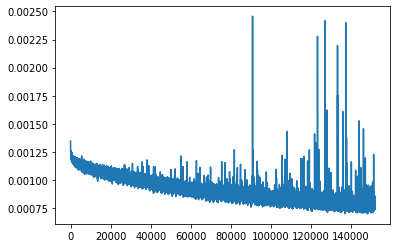

epoch: 82 	 step:0 	 loss: 0.0007388
epoch: 82 	 step:100 	 loss: 0.0008086
epoch: 82 	 step:200 	 loss: 0.0008054
epoch: 82 	 step:300 	 loss: 0.0007727
epoch: 82 	 step:400 	 loss: 0.0007569
epoch: 82 	 step:500 	 loss: 0.0007609
epoch: 82 	 step:600 	 loss: 0.0007631
epoch: 82 	 step:700 	 loss: 0.0007849
epoch: 82 	 step:800 	 loss: 0.0007248
epoch: 82 	 step:900 	 loss: 0.0008016
epoch: 82 	 step:1000 	 loss: 0.0007661
epoch: 82 	 step:1100 	 loss: 0.0007637
epoch: 82 	 step:1200 	 loss: 0.0007882
epoch: 82 	 step:1300 	 loss: 0.0008078
epoch: 82 	 step:1400 	 loss: 0.0007596
epoch: 82 	 step:1500 	 loss: 0.0007773
epoch: 82 	 step:1600 	 loss: 0.0007589
epoch: 82 	 step:1700 	 loss: 0.0007732
epoch: 82 	 step:1800 	 loss: 0.0007889


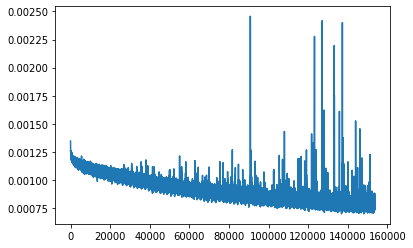

epoch: 83 	 step:0 	 loss: 0.0007532
epoch: 83 	 step:100 	 loss: 0.000756
epoch: 83 	 step:200 	 loss: 0.000775
epoch: 83 	 step:300 	 loss: 0.0007388
epoch: 83 	 step:400 	 loss: 0.0007548
epoch: 83 	 step:500 	 loss: 0.0007537
epoch: 83 	 step:600 	 loss: 0.0007723
epoch: 83 	 step:700 	 loss: 0.0008483
epoch: 83 	 step:800 	 loss: 0.0007849
epoch: 83 	 step:900 	 loss: 0.0007968
epoch: 83 	 step:1000 	 loss: 0.0007822
epoch: 83 	 step:1100 	 loss: 0.0007787
epoch: 83 	 step:1200 	 loss: 0.0008077
epoch: 83 	 step:1300 	 loss: 0.0007868
epoch: 83 	 step:1400 	 loss: 0.000783
epoch: 83 	 step:1500 	 loss: 0.0007485
epoch: 83 	 step:1600 	 loss: 0.000776
epoch: 83 	 step:1700 	 loss: 0.0008098
epoch: 83 	 step:1800 	 loss: 0.0007809


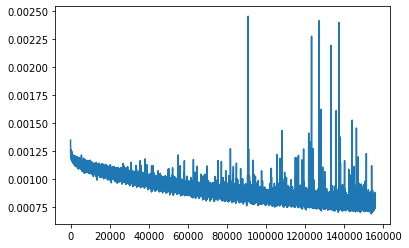

epoch: 84 	 step:0 	 loss: 0.0007474
epoch: 84 	 step:100 	 loss: 0.0007744
epoch: 84 	 step:200 	 loss: 0.0007476
epoch: 84 	 step:300 	 loss: 0.0007724
epoch: 84 	 step:400 	 loss: 0.0007597
epoch: 84 	 step:500 	 loss: 0.0007159
epoch: 84 	 step:600 	 loss: 0.0008057
epoch: 84 	 step:700 	 loss: 0.0007345
epoch: 84 	 step:800 	 loss: 0.000805
epoch: 84 	 step:900 	 loss: 0.0007599
epoch: 84 	 step:1000 	 loss: 0.0008188
epoch: 84 	 step:1100 	 loss: 0.0008008
epoch: 84 	 step:1200 	 loss: 0.0007672
epoch: 84 	 step:1300 	 loss: 0.0007992
epoch: 84 	 step:1400 	 loss: 0.0007871
epoch: 84 	 step:1500 	 loss: 0.0008195
epoch: 84 	 step:1600 	 loss: 0.0007828
epoch: 84 	 step:1700 	 loss: 0.0007915
epoch: 84 	 step:1800 	 loss: 0.0007746


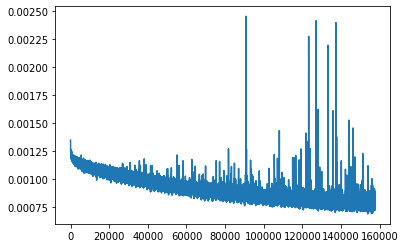

epoch: 85 	 step:0 	 loss: 0.0007576
epoch: 85 	 step:100 	 loss: 0.0007538
epoch: 85 	 step:200 	 loss: 0.0007825
epoch: 85 	 step:300 	 loss: 0.0007683
epoch: 85 	 step:400 	 loss: 0.00073
epoch: 85 	 step:500 	 loss: 0.0007931
epoch: 85 	 step:600 	 loss: 0.0007955
epoch: 85 	 step:700 	 loss: 0.0007657
epoch: 85 	 step:800 	 loss: 0.0007686
epoch: 85 	 step:900 	 loss: 0.0007633
epoch: 85 	 step:1000 	 loss: 0.0007671
epoch: 85 	 step:1100 	 loss: 0.0007736
epoch: 85 	 step:1200 	 loss: 0.0007648
epoch: 85 	 step:1300 	 loss: 0.0008119
epoch: 85 	 step:1400 	 loss: 0.0007472
epoch: 85 	 step:1500 	 loss: 0.0007835
epoch: 85 	 step:1600 	 loss: 0.0007823
epoch: 85 	 step:1700 	 loss: 0.0007698
epoch: 85 	 step:1800 	 loss: 0.0007883


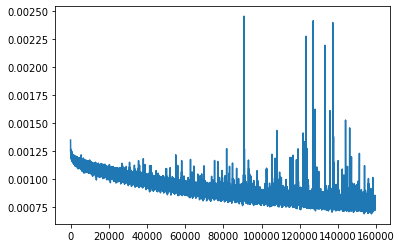

epoch: 86 	 step:0 	 loss: 0.0007344
epoch: 86 	 step:100 	 loss: 0.0007232
epoch: 86 	 step:200 	 loss: 0.0007699
epoch: 86 	 step:300 	 loss: 0.0007467
epoch: 86 	 step:400 	 loss: 0.0007263
epoch: 86 	 step:500 	 loss: 0.0007668
epoch: 86 	 step:600 	 loss: 0.0007895
epoch: 86 	 step:700 	 loss: 0.0007744
epoch: 86 	 step:800 	 loss: 0.0007603
epoch: 86 	 step:900 	 loss: 0.0007535
epoch: 86 	 step:1000 	 loss: 0.0007587
epoch: 86 	 step:1100 	 loss: 0.0007889
epoch: 86 	 step:1200 	 loss: 0.0007399
epoch: 86 	 step:1300 	 loss: 0.0007727
epoch: 86 	 step:1400 	 loss: 0.0007446
epoch: 86 	 step:1500 	 loss: 0.0007728
epoch: 86 	 step:1600 	 loss: 0.0007838
epoch: 86 	 step:1700 	 loss: 0.0008011
epoch: 86 	 step:1800 	 loss: 0.0007379


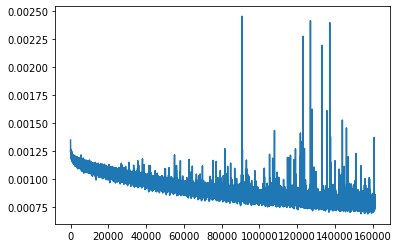

epoch: 87 	 step:0 	 loss: 0.000744
epoch: 87 	 step:100 	 loss: 0.0007279
epoch: 87 	 step:200 	 loss: 0.0007147
epoch: 87 	 step:300 	 loss: 0.0007642
epoch: 87 	 step:400 	 loss: 0.0007797
epoch: 87 	 step:500 	 loss: 0.0007456
epoch: 87 	 step:600 	 loss: 0.0007395
epoch: 87 	 step:700 	 loss: 0.0007517
epoch: 87 	 step:800 	 loss: 0.000818
epoch: 87 	 step:900 	 loss: 0.0007622
epoch: 87 	 step:1000 	 loss: 0.0007895
epoch: 87 	 step:1100 	 loss: 0.0008041
epoch: 87 	 step:1200 	 loss: 0.0007717
epoch: 87 	 step:1300 	 loss: 0.0008558
epoch: 87 	 step:1400 	 loss: 0.0007701
epoch: 87 	 step:1500 	 loss: 0.0007351
epoch: 87 	 step:1600 	 loss: 0.0007612
epoch: 87 	 step:1700 	 loss: 0.0007813
epoch: 87 	 step:1800 	 loss: 0.0007406


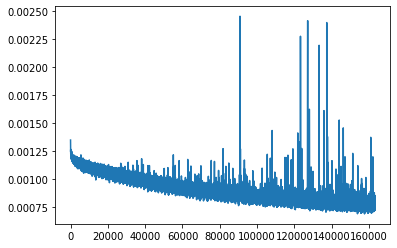

epoch: 88 	 step:0 	 loss: 0.0007513
epoch: 88 	 step:100 	 loss: 0.0007324
epoch: 88 	 step:200 	 loss: 0.0007338
epoch: 88 	 step:300 	 loss: 0.0007582
epoch: 88 	 step:400 	 loss: 0.0007506
epoch: 88 	 step:500 	 loss: 0.0007876
epoch: 88 	 step:600 	 loss: 0.0007694
epoch: 88 	 step:700 	 loss: 0.0007457
epoch: 88 	 step:800 	 loss: 0.0007379
epoch: 88 	 step:900 	 loss: 0.0007768
epoch: 88 	 step:1000 	 loss: 0.0007346
epoch: 88 	 step:1100 	 loss: 0.0007646
epoch: 88 	 step:1200 	 loss: 0.0007957
epoch: 88 	 step:1300 	 loss: 0.0007475
epoch: 88 	 step:1400 	 loss: 0.0007776
epoch: 88 	 step:1500 	 loss: 0.0007687
epoch: 88 	 step:1600 	 loss: 0.0007866
epoch: 88 	 step:1700 	 loss: 0.0007788
epoch: 88 	 step:1800 	 loss: 0.0007753


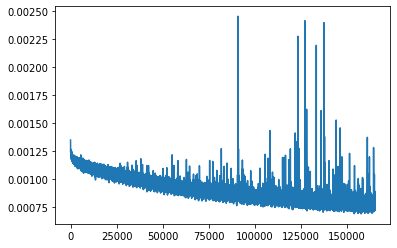

epoch: 89 	 step:0 	 loss: 0.0007575
epoch: 89 	 step:100 	 loss: 0.0007449
epoch: 89 	 step:200 	 loss: 0.0007501
epoch: 89 	 step:300 	 loss: 0.0007477
epoch: 89 	 step:400 	 loss: 0.000743
epoch: 89 	 step:500 	 loss: 0.0007546
epoch: 89 	 step:600 	 loss: 0.0007673
epoch: 89 	 step:700 	 loss: 0.0007868
epoch: 89 	 step:800 	 loss: 0.0007451
epoch: 89 	 step:900 	 loss: 0.0007664
epoch: 89 	 step:1000 	 loss: 0.0007561
epoch: 89 	 step:1100 	 loss: 0.0007508
epoch: 89 	 step:1200 	 loss: 0.0007579
epoch: 89 	 step:1300 	 loss: 0.0007997
epoch: 89 	 step:1400 	 loss: 0.0008094
epoch: 89 	 step:1500 	 loss: 0.0008169
epoch: 89 	 step:1600 	 loss: 0.0007478
epoch: 89 	 step:1700 	 loss: 0.0007701
epoch: 89 	 step:1800 	 loss: 0.0007792


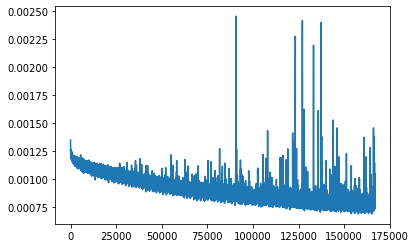

epoch: 90 	 step:0 	 loss: 0.0007108
epoch: 90 	 step:100 	 loss: 0.0007437
epoch: 90 	 step:200 	 loss: 0.0007451
epoch: 90 	 step:300 	 loss: 0.0007317
epoch: 90 	 step:400 	 loss: 0.0007672
epoch: 90 	 step:500 	 loss: 0.0007656
epoch: 90 	 step:600 	 loss: 0.0007409
epoch: 90 	 step:700 	 loss: 0.0007732
epoch: 90 	 step:800 	 loss: 0.0007738
epoch: 90 	 step:900 	 loss: 0.0007338
epoch: 90 	 step:1000 	 loss: 0.0007746
epoch: 90 	 step:1100 	 loss: 0.0007887
epoch: 90 	 step:1200 	 loss: 0.000789
epoch: 90 	 step:1300 	 loss: 0.0007695
epoch: 90 	 step:1400 	 loss: 0.0007514
epoch: 90 	 step:1500 	 loss: 0.0007722
epoch: 90 	 step:1600 	 loss: 0.0007889
epoch: 90 	 step:1700 	 loss: 0.0007653
epoch: 90 	 step:1800 	 loss: 0.0007665


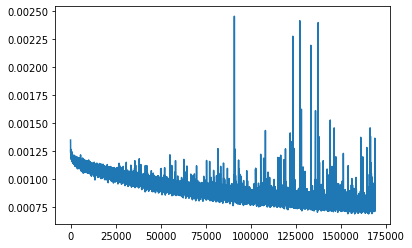

epoch: 91 	 step:0 	 loss: 0.0008192
epoch: 91 	 step:100 	 loss: 0.0007849
epoch: 91 	 step:200 	 loss: 0.0007316
epoch: 91 	 step:300 	 loss: 0.0007699
epoch: 91 	 step:400 	 loss: 0.0007784
epoch: 91 	 step:500 	 loss: 0.0007676
epoch: 91 	 step:600 	 loss: 0.0007833
epoch: 91 	 step:700 	 loss: 0.0007684
epoch: 91 	 step:800 	 loss: 0.0007526
epoch: 91 	 step:900 	 loss: 0.0007466
epoch: 91 	 step:1000 	 loss: 0.0007824
epoch: 91 	 step:1100 	 loss: 0.0007949
epoch: 91 	 step:1200 	 loss: 0.000753
epoch: 91 	 step:1300 	 loss: 0.0007359
epoch: 91 	 step:1400 	 loss: 0.000778
epoch: 91 	 step:1500 	 loss: 0.000779
epoch: 91 	 step:1600 	 loss: 0.000759
epoch: 91 	 step:1700 	 loss: 0.0007489
epoch: 91 	 step:1800 	 loss: 0.0007285


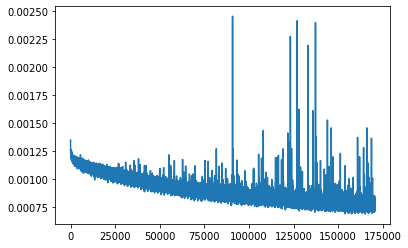

epoch: 92 	 step:0 	 loss: 0.000722
epoch: 92 	 step:100 	 loss: 0.0007363
epoch: 92 	 step:200 	 loss: 0.0007309
epoch: 92 	 step:300 	 loss: 0.0007321
epoch: 92 	 step:400 	 loss: 0.000772
epoch: 92 	 step:500 	 loss: 0.0007763
epoch: 92 	 step:600 	 loss: 0.0007784
epoch: 92 	 step:700 	 loss: 0.0007593
epoch: 92 	 step:800 	 loss: 0.0007777
epoch: 92 	 step:900 	 loss: 0.0007601
epoch: 92 	 step:1000 	 loss: 0.0007715
epoch: 92 	 step:1100 	 loss: 0.0007301
epoch: 92 	 step:1200 	 loss: 0.0007573
epoch: 92 	 step:1300 	 loss: 0.000757
epoch: 92 	 step:1400 	 loss: 0.0007761
epoch: 92 	 step:1500 	 loss: 0.0007844
epoch: 92 	 step:1600 	 loss: 0.0007502
epoch: 92 	 step:1700 	 loss: 0.0007477
epoch: 92 	 step:1800 	 loss: 0.0007561


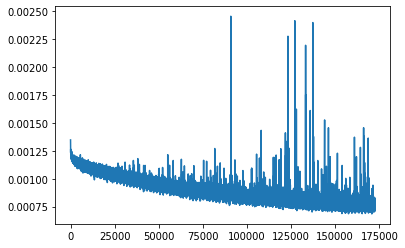

epoch: 93 	 step:0 	 loss: 0.0007311
epoch: 93 	 step:100 	 loss: 0.0007697
epoch: 93 	 step:200 	 loss: 0.0007508
epoch: 93 	 step:300 	 loss: 0.0007332
epoch: 93 	 step:400 	 loss: 0.0007525
epoch: 93 	 step:500 	 loss: 0.0007739
epoch: 93 	 step:600 	 loss: 0.0007535
epoch: 93 	 step:700 	 loss: 0.000801
epoch: 93 	 step:800 	 loss: 0.0007463
epoch: 93 	 step:900 	 loss: 0.0007564
epoch: 93 	 step:1000 	 loss: 0.000766
epoch: 93 	 step:1100 	 loss: 0.0007281
epoch: 93 	 step:1200 	 loss: 0.0008144
epoch: 93 	 step:1300 	 loss: 0.0007966
epoch: 93 	 step:1400 	 loss: 0.0007512
epoch: 93 	 step:1500 	 loss: 0.0007604
epoch: 93 	 step:1600 	 loss: 0.0007428
epoch: 93 	 step:1700 	 loss: 0.0007343
epoch: 93 	 step:1800 	 loss: 0.0007544


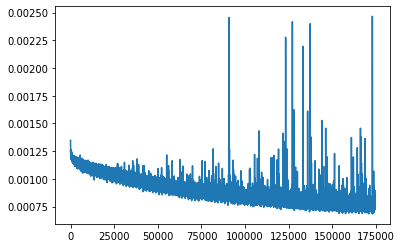

epoch: 94 	 step:0 	 loss: 0.0007122
epoch: 94 	 step:100 	 loss: 0.0007241
epoch: 94 	 step:200 	 loss: 0.0007411
epoch: 94 	 step:300 	 loss: 0.0007211
epoch: 94 	 step:400 	 loss: 0.0007313
epoch: 94 	 step:500 	 loss: 0.0007787
epoch: 94 	 step:600 	 loss: 0.0007834
epoch: 94 	 step:700 	 loss: 0.0007528
epoch: 94 	 step:800 	 loss: 0.0007628
epoch: 94 	 step:900 	 loss: 0.0007832
epoch: 94 	 step:1000 	 loss: 0.0007702
epoch: 94 	 step:1100 	 loss: 0.0007453
epoch: 94 	 step:1200 	 loss: 0.0007695
epoch: 94 	 step:1300 	 loss: 0.0007973
epoch: 94 	 step:1400 	 loss: 0.0007841
epoch: 94 	 step:1500 	 loss: 0.000772
epoch: 94 	 step:1600 	 loss: 0.000761
epoch: 94 	 step:1700 	 loss: 0.0007605
epoch: 94 	 step:1800 	 loss: 0.000764


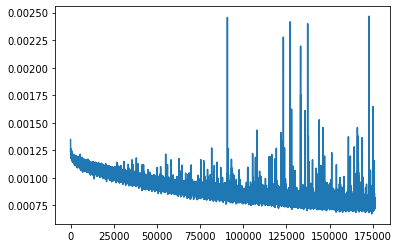

epoch: 95 	 step:0 	 loss: 0.0006772
epoch: 95 	 step:100 	 loss: 0.0007514
epoch: 95 	 step:200 	 loss: 0.0007505
epoch: 95 	 step:300 	 loss: 0.0007382
epoch: 95 	 step:400 	 loss: 0.0007181
epoch: 95 	 step:500 	 loss: 0.0007504
epoch: 95 	 step:600 	 loss: 0.0007174
epoch: 95 	 step:700 	 loss: 0.0008025
epoch: 95 	 step:800 	 loss: 0.0007406
epoch: 95 	 step:900 	 loss: 0.0007696
epoch: 95 	 step:1000 	 loss: 0.0007756
epoch: 95 	 step:1100 	 loss: 0.000762
epoch: 95 	 step:1200 	 loss: 0.000746
epoch: 95 	 step:1300 	 loss: 0.0007507
epoch: 95 	 step:1400 	 loss: 0.0007616
epoch: 95 	 step:1500 	 loss: 0.0007823
epoch: 95 	 step:1600 	 loss: 0.0007644
epoch: 95 	 step:1700 	 loss: 0.0007296
epoch: 95 	 step:1800 	 loss: 0.000813


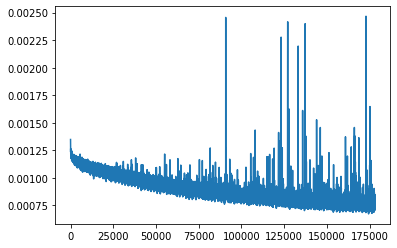

epoch: 96 	 step:0 	 loss: 0.0007519
epoch: 96 	 step:100 	 loss: 0.0007613
epoch: 96 	 step:200 	 loss: 0.000763
epoch: 96 	 step:300 	 loss: 0.0007499
epoch: 96 	 step:400 	 loss: 0.000742
epoch: 96 	 step:500 	 loss: 0.0006987
epoch: 96 	 step:600 	 loss: 0.0007146
epoch: 96 	 step:700 	 loss: 0.0007812
epoch: 96 	 step:800 	 loss: 0.0007309
epoch: 96 	 step:900 	 loss: 0.0007713
epoch: 96 	 step:1000 	 loss: 0.0007548
epoch: 96 	 step:1100 	 loss: 0.0007712
epoch: 96 	 step:1200 	 loss: 0.000749
epoch: 96 	 step:1300 	 loss: 0.0007489
epoch: 96 	 step:1400 	 loss: 0.000782
epoch: 96 	 step:1500 	 loss: 0.0007385
epoch: 96 	 step:1600 	 loss: 0.0007682
epoch: 96 	 step:1700 	 loss: 0.0007622
epoch: 96 	 step:1800 	 loss: 0.0007828


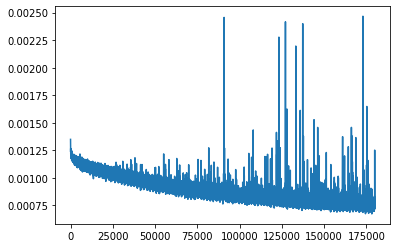

epoch: 97 	 step:0 	 loss: 0.000754
epoch: 97 	 step:100 	 loss: 0.0007203
epoch: 97 	 step:200 	 loss: 0.0006947
epoch: 97 	 step:300 	 loss: 0.0007275
epoch: 97 	 step:400 	 loss: 0.0007465
epoch: 97 	 step:500 	 loss: 0.0007743
epoch: 97 	 step:600 	 loss: 0.0007464
epoch: 97 	 step:700 	 loss: 0.0007429
epoch: 97 	 step:800 	 loss: 0.0007468
epoch: 97 	 step:900 	 loss: 0.0007524
epoch: 97 	 step:1000 	 loss: 0.0007785
epoch: 97 	 step:1100 	 loss: 0.0007582
epoch: 97 	 step:1200 	 loss: 0.0007596
epoch: 97 	 step:1300 	 loss: 0.0008109
epoch: 97 	 step:1400 	 loss: 0.0007525
epoch: 97 	 step:1500 	 loss: 0.0007327
epoch: 97 	 step:1600 	 loss: 0.0007457
epoch: 97 	 step:1700 	 loss: 0.0007717
epoch: 97 	 step:1800 	 loss: 0.0007634


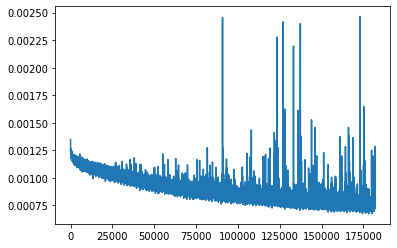

epoch: 98 	 step:0 	 loss: 0.0007908
epoch: 98 	 step:100 	 loss: 0.0007265
epoch: 98 	 step:200 	 loss: 0.0007651
epoch: 98 	 step:300 	 loss: 0.0007454
epoch: 98 	 step:400 	 loss: 0.0007334
epoch: 98 	 step:500 	 loss: 0.00075
epoch: 98 	 step:600 	 loss: 0.0007714
epoch: 98 	 step:700 	 loss: 0.0007237
epoch: 98 	 step:800 	 loss: 0.0007179
epoch: 98 	 step:900 	 loss: 0.0007243
epoch: 98 	 step:1000 	 loss: 0.0007176
epoch: 98 	 step:1100 	 loss: 0.0007861
epoch: 98 	 step:1200 	 loss: 0.0007245
epoch: 98 	 step:1300 	 loss: 0.0007563
epoch: 98 	 step:1400 	 loss: 0.0007392
epoch: 98 	 step:1500 	 loss: 0.000747
epoch: 98 	 step:1600 	 loss: 0.0007954
epoch: 98 	 step:1700 	 loss: 0.000777
epoch: 98 	 step:1800 	 loss: 0.0007544


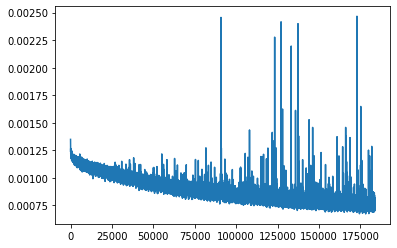

epoch: 99 	 step:0 	 loss: 0.0007533
epoch: 99 	 step:100 	 loss: 0.0007283
epoch: 99 	 step:200 	 loss: 0.0007195
epoch: 99 	 step:300 	 loss: 0.0007161
epoch: 99 	 step:400 	 loss: 0.0007321
epoch: 99 	 step:500 	 loss: 0.0007387
epoch: 99 	 step:600 	 loss: 0.0007465
epoch: 99 	 step:700 	 loss: 0.0007546
epoch: 99 	 step:800 	 loss: 0.0007711
epoch: 99 	 step:900 	 loss: 0.0007465
epoch: 99 	 step:1000 	 loss: 0.0007661
epoch: 99 	 step:1100 	 loss: 0.0007564
epoch: 99 	 step:1200 	 loss: 0.0008097
epoch: 99 	 step:1300 	 loss: 0.0007116
epoch: 99 	 step:1400 	 loss: 0.0007746
epoch: 99 	 step:1500 	 loss: 0.000757
epoch: 99 	 step:1600 	 loss: 0.0007423
epoch: 99 	 step:1700 	 loss: 0.0007333
epoch: 99 	 step:1800 	 loss: 0.0007569


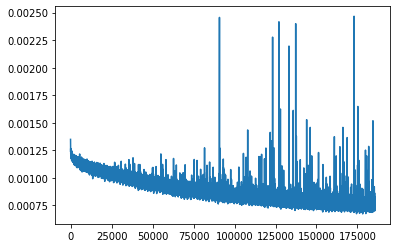

epoch: 100 	 step:0 	 loss: 0.0007296
epoch: 100 	 step:100 	 loss: 0.00076
epoch: 100 	 step:200 	 loss: 0.0007284
epoch: 100 	 step:300 	 loss: 0.0007453
epoch: 100 	 step:400 	 loss: 0.0007522
epoch: 100 	 step:500 	 loss: 0.0007996
epoch: 100 	 step:600 	 loss: 0.0007395
epoch: 100 	 step:700 	 loss: 0.0007601
epoch: 100 	 step:800 	 loss: 0.0007261
epoch: 100 	 step:900 	 loss: 0.0007555
epoch: 100 	 step:1000 	 loss: 0.0007513
epoch: 100 	 step:1100 	 loss: 0.0007628
epoch: 100 	 step:1200 	 loss: 0.000756
epoch: 100 	 step:1300 	 loss: 0.00075
epoch: 100 	 step:1400 	 loss: 0.0007865
epoch: 100 	 step:1500 	 loss: 0.0007608
epoch: 100 	 step:1600 	 loss: 0.0007994
epoch: 100 	 step:1700 	 loss: 0.000729
epoch: 100 	 step:1800 	 loss: 0.0007138


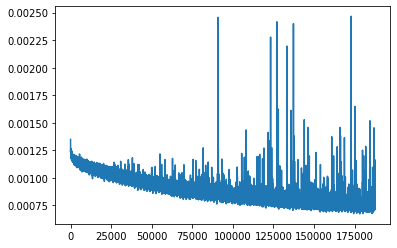

In [14]:
### TRAIN MODEL ###

num_epochs = 100

history = train_model(gen, opt, device, dataloader['train'], epochs=num_epochs)

In [15]:
def test_generator(model, device, testloader, one_batch=False):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        data = data.to(device=device)
        test_images.append(data.cpu().numpy())
        _, magn, _ = calc_fourier(data)
        out_Phs = model(magn)
        out_phs = torch.rfft(out_Phs, 2, onesided=False)
        out_phs = out_phs / torch.norm(out_phs, dim=-1)[..., None]
        out_ft = magn[..., None] * out_phs
        out = torch.irfft(out_ft, 2, onesided=False)
        
        outputs.append(out.cpu().detach().numpy())
        if one_batch: break
    
    return np.concatenate(test_images), np.concatenate(outputs)

In [16]:
# Calculate test predictions #

test_original, test_predicted = test_generator(gen, device, dataloader['test'])
print(test_original.shape)
print(test_predicted.shape)

(8000, 1, 28, 28)
(8000, 1, 28, 28)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


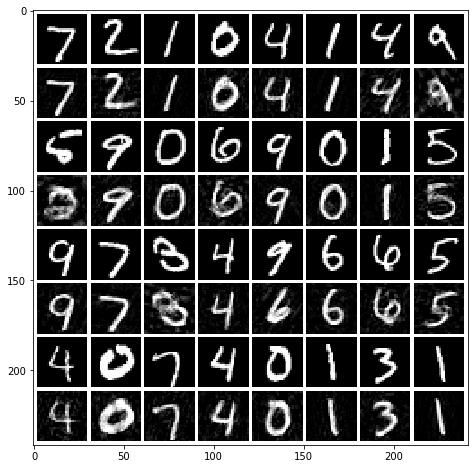

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


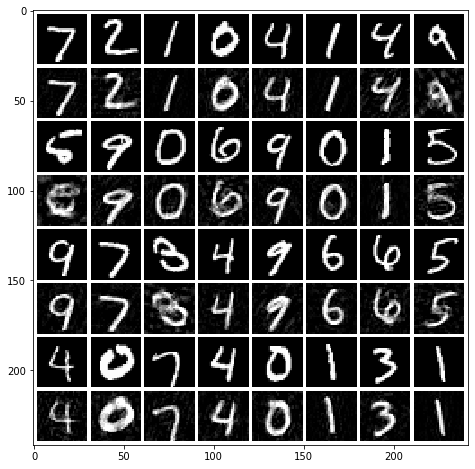

In [17]:
# Print predictions #
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    test_predicted[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8), file="../out/MNIST/end-to-end/phase-prediction/phase-real.png")

print("Registered:")
results_reg = register_croco(test_predicted[:32], test_original[:32])
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/MNIST/end-to-end/phase-prediction/phase-real-reg.png")

In [18]:
# Benchmark test predictions #

benchmark(pred=test_predicted[:1024], true=test_original[:1024], check_all=True)

Signal error:
  MSE: 0.029375694812756592, std: 0.02220093980213068
  MAE: 0.1030727569523151, std: 0.041212953770994855
  SSIM: 0.6361489321867724, std: 0.15444370447852868
  Sharpness: 0.17152282324800944, std: 0.052405735336540235
  PhCo-MSE: 0.028570222099801867, std: 0.022943501400056177
  PhCo-MAE: 0.10217519613615877, std: 0.04190275233690986
  PhCo-SSIM: 0.6384009840886284, std: 0.1531729164296225
  CroCo-MSE: 0.022608753576264462, std: 0.014142877897968646
  CroCo-MAE: 0.09502130856526492, std: 0.03520518670614705
  CroCo-SSIM: 0.6738323204365839, std: 0.12044852233619029

Magnitude error:
  MSE Magnitude: 3.0342059287565894e-12, std: 1.2737182994610266e-12

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [-0.74, 1.95] - should be in [0, 1]

Markdown table values:
 0.02938 | 0.1031 | 0.6361 | 0.1715 | 0.02857 | 0.1022 | 0.6384 | 0.02261 | 0.09502 | 0.6738 | 0.000000000003034 |


## Evaluation for different FC  (1024 samples)


| Nr | Loss | Size | epochs| MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | L2 | 2048 | 50 | 0.02831 | 0.1020 | 0.6394 | 0.1718 | 0.02701 | 0.1004 | 0.6440 | 0.02204 | 0.09431 | 0.6746 | 0.000000000003017 |
| 2 | L2 | 2048 | 100 | 0.02938 | 0.1031 | 0.6361 | 0.1715 | 0.02857 | 0.1022 | 0.6384 | 0.02261 | 0.09502 | 0.6738 | 0.000000000003034 |

Signal error:
  MSE: 0.029375694812756592, std: 0.02220093980213068
  MAE: 0.1030727569523151, std: 0.041212953770994855
  SSIM: 0.6361489321867724, std: 0.15444370447852868
  Sharpness: 0.17152282324800944, std: 0.052405735336540235
  PhCo-MSE: 0.028570222099801867, std: 0.022943501400056177
  PhCo-MAE: 0.10217519613615877, std: 0.04190275233690986
  PhCo-SSIM: 0.6384009840886284, std: 0.1531729164296225
  CroCo-MSE: 0.022608753576264462, std: 0.014142877897968646
  CroCo-MAE: 0.09502130856526492, std: 0.03520518670614705
  CroCo-SSIM: 0.6738323204365839, std: 0.12044852233619029

Magnitude error:
  MSE Magnitude: 3.0342059287565894e-12, std: 1.2737182994610266e-12

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [-0.74, 1.95] - should be in [0, 1]